In [11]:
import psycopg2 as pg2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from Player_rank import Player_ranker
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
import tensorflow as tf
import scipy.stats as scs
%matplotlib inline


In [2]:
'''
Here we're loading in all of the traditional Fantasy basketball stats into SQL, using window function to get a ranking by minutes

'''

"\nHere we're loading in all of the traditional Fantasy basketball stats into SQL, using window function to get a ranking by minutes\n\n"

In [3]:
'''IF you have open connections run the following in the psql command prompt:

SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = 'nba_capstone';

'''

"IF you have open connections run the following in the psql command prompt:\n\nSELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = 'nba_capstone';\n\n"

In [2]:
conn = pg2.connect(dbname = 'postgres',host='localhost')


In [3]:
conn.autocommit = True

In [4]:
cur = conn.cursor()


In [5]:
'''Note for some reason you can not access the database if it is not all lowercase'''

cur.execute('DROP DATABASE IF EXISTS nba_capstone;')  # Makes sure there is not already a class_example database and removes is if there is
cur.execute('CREATE DATABASE nba_capstone;')



In [6]:
cur.close()
conn.close()

In [2]:
conn = pg2.connect(dbname = 'nba_capstone',host='localhost')
conn.autocommit = True

In [3]:
cur = conn.cursor()


In [11]:
query = '''
        CREATE TABLE NBA_stats (
            Season integer, 
            Player varchar(50), 
            Pos varchar(10),
            Age int,
            Tm varchar(15),
            G int,
            GS int,
            MP float,
            FG float,
            FGA float,
            FG_Percentage float,
            Threes_Made float,
            Threes_Attempted float,
            Three_Percentage float,
            Twos_Made float,
            Twos_Attempted float,
            Twos_Percentage float,
            eff_FG_Percentage float,
            FTM float,
            FTA float,
            FT_Percentage float,
            ORB float,
            DRB float,
            Rebounds float,
            AST float,
            STL float,
            BLK float,
            TOV float,
            Fouls float,
            Points float
        );
        '''

cur.execute(query)

In [12]:
# import os
# current_directory_path = os.getcwd()
# current_directory_path

query = '''
        COPY NBA_stats 
        FROM '/Users/rcheer/Desktop/Galvanize/Capstone/Fantasy-Basketball-Capstone-Project/NBA stats.csv' 
        DELIMITER ',' 
        CSV HEADER;
        '''



cur.execute(query)

In [13]:
query = '''
        CREATE TABLE nba_advanced (
            Season integer, 
            Player varchar(50), 
            Pos varchar(10),
            Age int,
            Tm varchar(15),
            G int,
            total_MP float,
            PER float,
            True_Shooting float,
            Three_Attempt_Rate float,
            FT_rate float,
            ORB_Percentage float,
            DRB_Percentage float,
            Rebound_Percentage float,
            Assist_Percentage float,
            Steal_Percentage float,
            Block_Percentage float,
            Turnover_Percentage float,
            Usage_Percentage float,
            Offensive_WinShares float,
            Defensive_WinShares float,
            WinShares float,
            WinShares_Per48 float,
            Offensive_BoxPlusMinus float,
            Defensive_BoxPlusMinus float,
            BoxPlusMinus float,
            Value_overReplacement float
        );
        '''

cur.execute(query)

In [14]:
query = '''
        COPY nba_advanced 
        FROM '/Users/rcheer/Desktop/Galvanize/Capstone/Fantasy-Basketball-Capstone-Project/NBA Advanced.csv' 
        DELIMITER ',' 
        CSV HEADER;
        '''



cur.execute(query)

In [928]:
'''
save for later
d.points,d.rebounds,d.ast,d.stl,d.blk,d.tov,d.fg_percentage,d.FT_percentage
'''


query1 = '''
            update nba_stats set Tm = 'NOP' where Tm = 'NOH';
            update nba_advanced set Tm = 'NOP' where Tm = 'NOH';
            update nba_stats set Tm = 'CHA' where Tm = 'CHO';
            update nba_advanced set Tm = 'CHA' where Tm = 'CHO';
            
            DROP TABLE IF EXISTS players;
            CREATE TABLE players AS
            select season,player,max(G) as Games from NBA_stats where Tm!='TOT' group by season,player;
            
            DROP TABLE IF EXISTS y_predictions;
            CREATE TABLE y_predictions AS
            select d.season,d.player,d.pos,d.age,MAX(case when p.player is not null then d.Tm else NULL end) as StartingTeam,SUM(G) as Games,SUM(GS) as GS,
            max(MP) as minutes
            from NBA_stats d
            left join players p
                on d.season = p.season
                and d.player = p.player
                and d.G = p.Games
            where d.Tm!='TOT'
            group by d.season,d.player,d.pos,d.age;
            
            update y_predictions set StartingTeam = 'NOP' where startingTeam = 'NOH';
            update y_predictions set StartingTeam = 'CHA' where startingTeam = 'CHO';
            
            DROP TABLE IF EXISTS rank_by_minutes;
            CREATE TABLE rank_by_minutes AS
            select y.*,n.points,n.rebounds,n.ast,n.stl,n.blk,n.tov,n.threes_made,n.fg,n.fga,n.ftm,n.fta,
            case when cast(y.GS as float)/y.Games >0.6 then 1 else 0 end as starter,
            row_number() over(partition by n.season order by MP*G desc) as min_rank from NBA_stats n
            inner join y_predictions y
                ON n.player = y.player
                and n.season = y.season
                and n.Tm=y.startingTeam;
            
            DROP TABLE IF EXISTS adv_withminrank;
            CREATE TABLE adv_withminrank AS
            select y.*,n.per,n.true_shooting,n.three_attempt_rate,n.ft_rate,n.rebound_percentage,n.assist_percentage
            ,n.steal_percentage,n.block_percentage,n.turnover_percentage,n.usage_percentage,n.offensive_winshares,
            n.defensive_winshares,winshares,winshares_per48,offensive_boxplusminus,defensive_boxplusminus,boxplusminus,value_overreplacement,
            case when cast(y.GS as float)/y.Games >0.6 then 1 else 0 end as starter,
            row_number() over(partition by n.season order by total_mp desc) as min_rank from NBA_advanced n
            inner join y_predictions y
                ON n.player = y.player
                and n.season = y.season
                and n.Tm=y.startingTeam;
            
            
            select * from rank_by_minutes        
                
        '''
cur.execute(query1)
data = cur.fetchall()
df = pd.DataFrame(np.array(data))
df.columns = ['season','player','position','age','team','gamesPlayed','gamesStarted','minutes'
              ,'points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','starter','min_rank']


In [16]:
df['min_rank']=pd.to_numeric(df['min_rank'])
df['points']=pd.to_numeric(df['points'])
df['rebounds']=pd.to_numeric(df['rebounds'])
df['assists']=pd.to_numeric(df['assists'])
df['steals']=pd.to_numeric(df['steals'])
df['blocks']=pd.to_numeric(df['blocks'])
df['turnovers']=pd.to_numeric(df['turnovers'])
df['threes_made']=pd.to_numeric(df['threes_made'])
df['FGM']=pd.to_numeric(df['FGM'])
df['FGA']=pd.to_numeric(df['FGA'])
df['FTM']=pd.to_numeric(df['FTM'])
df['FTA']=pd.to_numeric(df['FTA'])
df['gamesPlayed']=pd.to_numeric(df['gamesPlayed'])
df['gamesStarted']=pd.to_numeric(df['gamesStarted'])
df['minutes']=pd.to_numeric(df['minutes'])
df['age']=pd.to_numeric(df['age'])
df['season']=pd.to_numeric(df['season'])




In [1297]:
for i in df.columns:
    if i not in ['player','team','position']:
        df[i]=pd.to_numeric(df[i])

In [17]:
test = Player_ranker(df)
test.get_category_dist()
test.cat_mean

,season,mean_points,mean_rebounds,mean_assists,mean_steals,mean_blocks,mean_turnovers,mean_threes_made,mean_fgm,mean_fga,mean_ftm,mean_fta
0,2008,13.3005,5.1235,2.7870,0.9150,0.5690,1.7035,0.8780,4.9095,10.5850,2.5990,3.3115
1,2009,12.9850,5.1080,2.8490,0.9120,0.5600,1.6965,0.8265,4.8530,10.4370,2.4600,3.1825
2,2010,12.9225,5.0185,2.8135,0.9085,0.5685,1.6790,0.8380,4.7955,10.3525,2.4955,3.2005
3,2011,12.1830,4.8915,2.6840,0.9225,0.5725,1.6805,0.8030,4.5925,10.1180,2.1955,2.8590
4,2012,12.5550,5.0520,2.8840,0.9585,0.6125,1.7410,0.8800,4.7285,10.3275,2.2150,2.8920
5,2013,13.0510,5.1265,2.8310,0.9505,0.5420,1.7375,0.9715,4.8545,10.5425,2.3790,3.1020
6,2014,12.3805,4.9890,2.7145,0.9230,0.5390,1.6315,0.9600,4.6260,10.1940,2.1725,2.8505
7,2015,12.8715,5.1935,2.7720,0.9530,0.5900,1.6785,1.0530,4.7645,10.4595,2.2840,2.9900
8,2016,13.3550,5.0420,2.8950,0.9230,0.5340,1.6195,1.2170,4.8980,10.6355,2.3385,2.9850
9,2017,13.2915,5.0950,2.9355,0.9240,0.5585,1.6825,1.3200,4.9175,10.6135,2.1395,2.7465


In [18]:
test.assign_values()

In [19]:
value_copy = test.value.copy()

In [20]:
value_copy.head()

,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
0,2008,Andre Iguodala,1.569149,1.022902,0.233549,1.209232,-0.313073,1.720216,-1.392654,0.164932,0.201353,-1.277308
1,2008,Joe Johnson,2.248938,1.506499,-0.293101,1.449827,-0.683573,0.464584,-1.113145,1.381647,-1.036752,0.572951
2,2008,O.J. Mayo,0.491912,0.967102,-0.536170,0.198732,-0.683573,0.464584,-1.532409,1.246456,-0.633993,1.001183
3,2008,Antawn Jamison,3.459954,1.655298,1.529918,-0.426816,-0.498323,0.715710,0.284401,0.705694,0.083254,-0.589183
4,2008,Raymond Felton,-0.135656,0.167306,-0.536170,1.882899,-0.313073,1.469090,-1.532409,-0.240639,-1.364914,0.332253


In [21]:
#copy value data back into SQL
engine = create_engine("postgresql://@localhost/nba_capstone")

value_copy.to_sql(name='value', con=engine, if_exists = 'replace', index=False)


In [22]:
query = '''
        DROP TABLE IF EXISTS player_value;
        CREATE TABLE player_value AS
        select ROW_NUMBER() OVER(PARTITION BY season ORDER BY value_tot DESC),* from value;
        
        DROP TABLE IF EXISTS value;
        
        select * from player_value;
        
        '''


cur.execute(query)
ranking_data = cur.fetchall()
df_2 = pd.DataFrame(np.array(ranking_data))
cols_value = ['playerrank']
for item in (list(value_copy.columns)):
    cols_value.append(item)
cols_value
df_2.columns=cols_value

In [23]:
for i in df_2.columns:
    if i!='player':
        df_2[i]=pd.to_numeric(df_2[i])



In [24]:
for i in df_2.columns:
    if i!='player':
        df_2[i]=pd.to_numeric(df_2[i])

In [25]:
df_2.head()

,playerrank,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
0,1,2008,Chris Paul,10.649584,1.766898,0.152526,3.952019,-0.868823,4.733733,-1.811918,-0.105449,1.195183,1.635414
1,2,2008,LeBron James,8.708530,2.808492,1.003268,2.123494,0.983678,1.971343,-1.811918,0.976075,0.888138,-0.234041
2,3,2008,Dwyane Wade,8.419529,3.143291,-0.050032,2.267852,1.354178,3.226975,-2.370936,0.300123,1.126183,-0.578103
3,4,2008,Danny Granger,6.463654,2.324895,-0.009520,-0.041864,1.539428,0.213457,-1.113145,2.463170,-0.678128,1.765360
4,5,2008,Dirk Nowitzki,6.094625,2.343495,1.327360,-0.186221,0.427928,-0.288795,-0.274618,-0.105449,0.611555,2.239370


In [26]:
df_2[df_2['season']==2017].sort_values(by='playerrank', ascending=True)

,playerrank,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
4219,1,2017,Anthony Davis,13.069292,2.728406,2.327843,-0.323373,4.382346,1.403769,-0.642579,-0.719758,2.572502,1.340136
4220,2,2017,Stephen Curry,10.977767,2.415188,0.001938,1.610250,-0.769567,1.647478,-1.635937,3.343394,1.073741,3.291282
4221,3,2017,Kevin Durant,10.555627,2.415188,0.660945,1.254056,2.665042,-0.545910,-1.635937,1.369863,1.809299,2.563082
4222,4,2017,James Harden,10.522310,3.152171,0.118234,2.984140,0.303748,2.134898,-3.374314,2.762944,-0.589500,3.029989
4223,5,2017,Karl-Anthony Towns,9.046572,1.475533,2.793024,-0.272488,1.806390,-0.302200,-0.270069,0.208962,2.213129,1.394291
4224,6,2017,LeBron James,8.050018,2.617858,1.358716,3.136795,0.733074,1.160059,-3.125975,0.557232,2.935558,-1.323300
4225,7,2017,Giannis Antetokounmpo,7.982516,2.507311,1.901427,0.948747,1.806390,1.403769,-1.635937,-0.835849,2.328774,-0.442116
4226,8,2017,Damian Lillard,7.758411,2.507311,-0.230652,1.864674,-0.340241,0.428929,-1.387598,2.066403,-0.920536,3.770119
4227,9,2017,Chris Paul,7.259998,0.978069,0.118234,2.526177,-0.769567,1.891188,-0.642579,1.369863,-0.176916,1.965529
4228,10,2017,Jimmy Butler,7.194467,1.641355,0.079468,0.999632,-0.340241,2.622318,-0.145900,-0.139308,0.324360,2.152782


In [1045]:
''' Creating all teammate based changes
'''



query = '''
        DROP TABLE IF EXISTS adv_top10min;
        CREATE TABLE adv_top10min as 
        select a.*,usage_percentage*total_MP/G as usage_withMins,row_number() over(partition by a.season,tm order by usage_percentage*total_MP/G desc) as usage_rank
        from(select *,row_number() over(partition by season,tm order by total_MP desc) as min_rank from nba_advanced) a
        inner join y_predictions y
                ON a.player = y.player
                and a.season = y.season
                and a.Tm=y.startingTeam
        where min_rank<=10;
        
        DROP TABLE IF EXISTS Change_Teams;
        CREATE TABLE Change_Teams AS
        select na.tm as old_team,na2.tm as new_team,na2.player,na2.pos,p.season,na.usage_withMins,
        n.points,n.rebounds,n.ast,n.threes_made,na.usage_rank 
        from player_value p
        inner join adv_top10min na
            on p.player = na.player
            and p.season = na.season+1
        inner join adv_top10min na2
            on na2.player = na.player
            and na2.season = p.season
            and na2.tm != na.tm
        inner join rank_by_minutes n
            ON N.player = na.player
            and n.season = na.season;
        
        
        
        DROP TABLE IF EXISTS incoming_by_team;
        CREATE TABLE incoming_by_team AS
        select new_team,season,SUM(case when usage_withmins >1000 then 1 else 0 end) as high_usageplayer_added,
        SUM(usage_withmins) as usagemin_added, MAX(usage_withmins) as max_usageadded,
        SUM(points) as points_added, MAX(points) as max_pointsadded,SUM(rebounds) as rebounds_added,
        MAX(rebounds) as max_reboundsadded, SUM(ast) as ast_added, MAX(ast) as max_astadded,
        SUM(threes_made) as threes_added, MAX(threes_made) as max_threesadded 
        from change_teams
        group by new_team,season;
        
        DROP TABLE IF EXISTS outgoing_by_team;
        CREATE TABLE outgoing_by_team AS
        select old_team,season,SUM(case when usage_withmins >1000 then 1 else 0 end) as high_usageplayer_dropped,
        SUM(usage_withmins) as usagemin_dropped, MAX(usage_withmins) as max_usagedropped,
        SUM(points) as points_dropped, MAX(points) as max_pointsdropped,SUM(rebounds) as rebounds_dropped,
        MAX(rebounds) as max_reboundsdropped, SUM(ast) as ast_dropped, MAX(ast) as max_astdropped,
        SUM(threes_made) as threes_dropped, MAX(threes_made) as max_threesdropped
        from change_teams
        group by old_team,season;
        
        DROP TABLE IF EXISTS Team_Changes;
        CREATE TABLE Team_Changes AS
        select c.new_team as team, c.season,c.high_usageplayer_added,o.usagemin_dropped-c.usagemin_added as usagemin_opened,
        c.max_usageadded,o.high_usageplayer_dropped,o.max_usagedropped,
        o.points_dropped-c.points_added as points_opened,max_pointsdropped,max_pointsadded,
        o.rebounds_dropped-c.rebounds_added as rebounds_opened,max_reboundsdropped,max_reboundsadded,
        o.ast_dropped-c.ast_added as ast_opened,max_astdropped,max_astadded,
        o.threes_dropped-c.threes_added as threes_opened,max_threesdropped,max_threesadded
        from incoming_by_team c
        inner join outgoing_by_team o
            ON o.old_team = c.new_team
            and o.season = c.season;
            
        DROP TABLE IF EXISTS Teammate_maxes;
        CREATE TABLE Teammate_maxes AS
        select R.season,R.startingTeam,R.player,MAX(R2.points) as max_teammatepts, max(r2.rebounds) as max_teammatereb, max(r2.ast) as max_teammateast,
        MAX(R2.Tov) as max_teammateTO,MAX(r2.FGA) as max_teammateshot_attempts, cast(NULL as float) as max_teammate_usage 
        from rank_by_minutes R
        inner join rank_by_minutes R2
            ON R2.startingTeam = R.startingTeam
            and R2.season+1 = R.season
            and R2.player != R.player
        group by R.season,R.startingTeam, R.player;
        
        
        --would like to change this to max teammate and usage usagewithmins rather than usage
        update Teammate_maxes T
        set max_teammate_usage = usagemins
        from
        (select T.season,T.startingTeam,T.player,MAX(a2.usage_withMins) as usagemins from Teammate_maxes T
        inner join adv_top10min a
            ON A.season = T.season
            and A.tm = T.startingteam
            and A.player != T.player
        inner join adv_top10min a2
            ON a2.season+1 = a.season
            and a2.player=a.player
        group by T.season,T.startingTeam,T.player) A
        WHERE A.season = T.season and  A.startingTeam = T.startingTeam and A.player = T.player;
        
        
        
        '''


cur.execute(query)

In [1047]:
''' Get player based data
'''



query = '''
        DROP TABLE IF EXISTS player_stats;
        CREATE TABLE player_stats AS
        select r.*,r2.starter as starter_ly,r2.points-r3.points as change_points_ly,r2.points as points_ly
        ,r2.rebounds-r3.rebounds as change_reb_ly, r2.rebounds as rebounds_ly,
        r2.ast-r3.ast as change_ast_ly, r2.ast as ast_ly,r2.stl-r3.stl as change_stl_ly,r2.stl as stl_ly,
        r2.blk-r3.blk as change_blk_ly, r2.blk as blk_ly,r2.tov-r3.tov as change_tov_ly,r2.tov as tov_ly,
        r2.threes_made as threes_ly,r2.threes_made-r3.threes_made as change_threes,r2.fg as fg_ly, r2.fga as fga_ly,
        r2.ftm as ftm_ly,r2.fta as fta_ly
        from rank_by_minutes r
        left join rank_by_minutes r2
            on r.player = r2.player
            and r.season = r2.season+1
        left join rank_by_minutes r3
            ON r3.player = r2.player
            and r3.season+1 = r2.season;
        
        DROP TABLE IF EXISTS player_advstats;
        CREATE TABLE player_advstats AS
        select y.player,y.season,y.startingteam,a.per as per_ly, a.per-a2.per as change_per,a.three_attempt_rate as threeAR_ly,
        a.three_attempt_rate-a2.three_attempt_rate as change_3AR, a.rebound_percentage as reb_perc_ly, a.rebound_percentage-a2.rebound_percentage as change_reb_perc
        ,a.assist_percentage as ast_perc_ly, a.assist_percentage-a2.assist_percentage as change_assist_perc
        ,a.steal_percentage as stl_perc_ly, a.steal_percentage-a2.steal_percentage as change_stl_perc_ly
        ,a.block_percentage as blk_perc_ly, a.block_percentage-a2.block_percentage as change_blk_perc_ly
        ,a.turnover_percentage as TO_perc_ly, a.turnover_percentage-a2.turnover_percentage as change_turnover_perc_ly,
        rank() over(partition by y.season,y.startingTeam order by cast(CONCAT(a.usage_percentage*a.minutes,0) as float) DESC) as usagerank,
        rank() over(partition by y.season,a.startingTeam order by a.usage_percentage DESC) as usagerank_ly,
        a.offensive_winshares,
        a.defensive_winshares,a.winshares,a.winshares_per48,a.offensive_boxplusminus,a.defensive_boxplusminus,
        a.boxplusminus,a.value_overreplacement        
        from y_predictions y
        left join adv_withminrank a
            ON a.player = y.player
            and a.season+1 = y.season
        left join adv_withminrank a2
            ON a2.player = a.player
            and a2.season+1 = a.season;
    
        
        DROP TABLE IF EXISTS player_careerstats;
        CREATE TABLE player_careerstats AS
        select r.player,r.season,SUM(case when r2.player is not null then 1 else 0 end) as YearsPro, SUM(r2.points*r2.games)/SUM(r2.games) as career_points
        ,SUM(r2.games*r2.rebounds)/SUM(r2.games) as career_rebounds,SUM(r2.games*r2.ast)/SUM(r2.games) as career_ast, SUM(r2.stl*r2.games)/SUM(r2.games) as career_stl
        ,SUM(r2.blk*r2.games)/SUM(r2.games) as career_blk,SUM(r2.tov*r2.games)/SUM(r2.games) as career_TO, SUM(r2.threes_made*r2.games)/SUM(r2.games) as career_threesmade
        ,avg(r2.ftm) as career_ftm,avg(r2.fta) as career_fta,avg(r2.fga) as career_fga, avg(r2.fg) as career_fgm
        from rank_by_minutes r
        inner join rank_by_minutes r2
            ON r.player = r2.player
            and r.season > r2.season
        group by r.player,r.season;
       
        '''


cur.execute(query)


In [4]:
'''testing leaving out 2017 and inputting predicted stats (Will later do this on 2018, but validating on 2017 first)'''
query = '''
        select * from rank_by_minutes where season = 2017;    
                
        '''
cur.execute(query)
data = cur.fetchall()
df_2017 = pd.DataFrame(np.array(data))
df_2017.columns = ['season','player','position','age','team','gamesPlayed','gamesStarted','minutes'
              ,'points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','starter','min_rank']

for i in df_2017.columns:
    if i not in(['player','position','team']):
        df_2017[i]=pd.to_numeric(df_2017[i])

rank_2017 = Player_ranker(df_2017)
rank_2017.get_category_dist()
rank_2017.assign_values()
rank_2017.value.head()
df_2017.head()

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,starter,min_rank
0,2017,LeBron James,PF,33,CLE,82,82,36.9,27.5,8.6,...,1.4,0.9,4.2,1.8,10.5,19.3,4.7,6.5,1,1
1,2017,Khris Middleton,SF,26,MIL,82,82,36.4,20.1,5.2,...,1.5,0.3,2.3,1.8,7.2,15.5,3.9,4.4,1,2
2,2017,Andrew Wiggins,SF,22,MIN,82,82,36.3,17.7,4.4,...,1.1,0.6,1.7,1.4,6.9,15.9,2.5,3.8,1,3
3,2017,Bradley Beal,SG,24,WAS,82,82,36.3,22.6,4.4,...,1.2,0.4,2.6,2.4,8.3,18.1,3.6,4.5,1,4
4,2017,CJ McCollum,SG,26,POR,81,81,36.1,21.4,4.0,...,1.0,0.4,1.9,2.3,8.2,18.6,2.6,3.1,1,5


In [5]:
 query= '''
        
        DROP TABLE IF EXISTS points_pred;
        CREATE TABLE points_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        points float, -- these come from player_stats
        points_ly float,
        change_points_ly float,
        starter_change int,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_points float,
        yearspro int
        );
        
        INSERT INTO points_pred(season,player,age,team,points,points_ly,change_points_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,points,points_ly,change_points_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update points_pred pp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = pp.team and pp.season=tc.season;
        
        update points_pred pp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where pp.player = pa.player and pp.season = pa.season and pp.team = pa.startingteam;
        
        update points_pred pp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = pp.season and tm.player = pp.player;
        
        update points_pred pp
        set career_points = pc.career_points, yearspro = pc.yearspro
        from player_careerstats pc
        where pp.player = pc.player and pp.season = pc.season;
        
        
        select * from points_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
points_df = pd.DataFrame(np.array(data))
points_df.columns = ['season','player','age','team','points','points_ly','change_points_ly','starter_change','Games','C_PF','PG','SG_SF','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','points_opened','max_pointsdropped',
                    'max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement',
                     'max_teammatepts','max_teammateusage','max_teammateto','max_teammateshot_attempts','career_points','yearspro']

In [33]:
rookies = points_df[points_df['points_ly'].isna()]
rookies.sort_values(by='points',ascending=False)

In [7]:
points_df['age_squared']=points_df['age']*points_df['age']
points = points_df[points_df['points_ly'].notna()]
for i in points.columns:
    if i not in(['player','team']):
        points[i]=pd.to_numeric(points[i])
points = points.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [146]:
y = points[(points['season']!=2017) & (points['Games']>30)]['points']
X = points[(points['season']!=2017) & (points['Games']>30)].drop(['points','player','season','team','Games'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [147]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7841272475695518
0.7815627162577581


In [611]:
r2_lr = np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=10,n_jobs=-1))
print('Linear Regression r2: {}'.format(r2_lr))

r2_gb = np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5,n_jobs=-1))
print('GradientBoost r2: {}'.format(r2_gb))

r2_rf = np.mean(cross_val_score(RandomForestRegressor(n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5,n_jobs=-1))
print('RandomForest r2: {}'.format(r2_rf))

Linear Regression r2: 0.7746187096528391
GradientBoost r2: 0.7715932876985157
RandomForest r2: 0.6962466937101812


In [65]:
parameters = {'learning_rate':[0.01,0.05,0.1], 'n_estimators':[1000,2000],'max_depth':[3,5,7,10],'max_features':[0.1,0.3,0.5]}

clf = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5,verbose=3)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7495924120019375, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7476594944544669, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7943399658158287, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7190431458804185, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=1000, score=0.7222216933630867, total=   0.3s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000, score=0.7627053638805009, total=   0.6s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000, score=0.7502206778411044, total=   0.6s
[CV] learning_rate=0.01, max_depth=3, max_features=0.1, n_estimators=2000 
[CV]  learning_rate=0.01, max_depth=3, max_fe

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 11.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [1000, 2000], 'max_depth': [3, 5, 7, 10], 'max_features': [0.1, 0.3, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [66]:
clf.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [594]:
X_train.head()

,age,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF,high_usageplayer_added,usagemin_opened,maxusage_added,...,per_ly,change_per,usagerank,usagerank_ly,offensive_winshares,offensive_boxplusminus,boxplusminus,value_overreplacement,career_points,yearspro
1879,24,16.4,-1.1,0,0,0,1,0.0,868.379858,673.950617,...,14.6,-0.9,18.0,51.0,2.1,-0.1,-0.5,0.9,15.366667,3
1626,26,10.0,-1.9,1,1,0,0,0.0,-152.301781,993.128302,...,17.8,-2.7,13.0,6.0,2.7,-1.5,0.0,1.0,7.333333,3
1705,22,6.3,0.0,0,1,0,0,0.0,-98.010991,428.000000,...,16.7,0.0,1.0,10.0,1.7,0.0,0.5,0.5,6.300000,1
1194,25,0.6,0.0,0,1,0,0,0.0,0.000000,0.000000,...,2.1,0.0,2.0,3.0,-0.1,-6.7,-7.7,-0.1,0.600000,1
3157,35,3.7,-0.5,0,1,0,0,1.0,-290.057346,1068.484507,...,10.1,1.1,1.0,1.0,1.3,-0.2,-0.9,0.3,5.742857,7


In [14]:
model = Sequential()
model.add(Dense(units=16,input_dim= X_train.shape[1],activation='relu'))
#model.add(Dense(units=8, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=8, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=4, activation='relu'))
#model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 0s 155us/step - loss: 1011.4472
Epoch 2/1000
1564/1564 [==============================] - 0s 9us/step - loss: 217.7783
Epoch 3/1000
1564/1564 [==============================] - 0s 8us/step - loss: 154.6964
Epoch 4/1000
1564/1564 [==============================] - 0s 8us/step - loss: 89.0590
Epoch 5/1000
1564/1564 [==============================] - 0s 8us/step - loss: 84.3199
Epoch 6/1000
1564/1564 [==============================] - 0s 8us/step - loss: 73.5923
Epoch 7/1000
1564/1564 [==============================] - 0s 9us/step - loss: 69.4950
Epoch 8/1000
1564/1564 [==============================] - 0s 10us/step - loss: 64.9251
Epoch 9/1000
1564/1564 [==============================] - 0s 11us/step - loss: 61.5691
Epoch 10/1000
1564/1564 [==============================] - 0s 9us/step - loss: 58.5428
Epoch 11/1000
1564/1564 [==============================] - 0s 8us/step - loss: 56.0940
Epoch 12/1000
1564/1564 [===================

In [15]:
predictions = model.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [24]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['points']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_scoring']=X_test['points_ly'].reset_index()['points_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.head()

print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_scoring'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:7.427404208809747
MSE using mean:31.18917117721401
MSE using last year stats:10.313487332339786
MSE using LR:6.571291145989944
MSE using GB:6.712042423801309
MSE using combo:6.469964458867595


In [34]:
pred_2017points = points[points['season']==2017].drop(['season','team','player','points','Games'],axis=1)
points_2017 = model.predict(pred_2017points)
test_2 =pd.DataFrame(points_2017)
gbr_pts_2017 = pd.DataFrame(gbr.predict(pred_2017points))
LR_pts_2017 = pd.DataFrame(LR.predict(pred_2017points))
test_3 = pd.merge(points,pred_2017points,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_pts_2017[0]
test_3['LR_pred'] = LR_pts_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','points','points_ly_x','predictions','gbr_pred','LR_pred','mean_pred']].sort_values(by='points_ly_x',ascending=False)

points_pred = test_3[['player','LR_pred','mean_pred']]
points_pred.columns = ['player','point_prediction1','point_prediction2']

df_2017 = pd.merge(df_2017,points_pred,how = 'left',left_on = 'player',right_on='player')

In [947]:
gbr.feature_importances_

array([0.09715074, 0.1687321 , 0.04240801, 0.06339758, 0.00168377,
       0.00236543, 0.00078106, 0.        , 0.02688646, 0.0145768 ,
       0.0004906 , 0.02614391, 0.02260494, 0.01884231, 0.05531208,
       0.04725459, 0.03733018, 0.0706518 , 0.04590708, 0.03301813,
       0.06606104, 0.02548585, 0.02077978, 0.04818103, 0.05865998,
       0.00529474])

In [36]:
'''next is rebounds'''


query= '''
        
        DROP TABLE IF EXISTS rebounds_pred;
        CREATE TABLE rebounds_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        rebounds float, -- these come from player_stats
        rebounds_ly float,
        change_rebounds_ly float,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        
        -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        rebounds_opened float,
        max_reboundsdropped float,
        max_reboundsadded float,
        
        -- from player_advstats
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        reb_perc_ly float,
        change_reb_perc float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatereb float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_rebounds float,
        yearspro int
        );
        
        INSERT INTO rebounds_pred(season,player,age,team,rebounds,rebounds_ly,change_rebounds_ly,Games,starter_change,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,rebounds,rebounds_ly,change_reb_ly,Games,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update rebounds_pred rp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,rebounds_opened=tc.rebounds_opened,
        max_reboundsdropped=tc.max_reboundsdropped,max_reboundsadded=tc.max_reboundsadded
        from team_changes tc
        where tc.team = rp.team and rp.season=tc.season;
        
        update rebounds_pred rp
        set per_ly=pa.per_ly,change_per=pa.change_per,usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly
        ,reb_perc_ly = pa.reb_perc_ly,change_reb_perc = pa.change_reb_perc,defensive_winshares=pa.defensive_winshares,
        defensive_boxplusminus=pa.defensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where rp.player = pa.player and rp.season = pa.season and rp.team = pa.startingteam;
        
        update rebounds_pred rp
        set max_teammatereb = tm.max_teammatereb,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = rp.season and tm.player = rp.player;
        
        update rebounds_pred rp
        set career_rebounds = pc.career_rebounds, yearspro = pc.yearspro
        from player_careerstats pc
        where rp.player = pc.player and rp.season = pc.season;
        
        
        select * from rebounds_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
rebounds_df = pd.DataFrame(np.array(data))
rebounds_df.columns = ['season','player','age','team','rebounds','rebounds_ly','change_rebounds_ly','Games','C_PF','PG','SG_SF','starter_change','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','rebounds_opened','max_reboundsdropped',
                    'max_reboundsadded','per_ly','change_per','usagerank','usagerank_ly','reb_perc_ly','change_reb_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement'
                       ,'max_teammatereb','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_rebounds','yearspro']

In [38]:
rebounds_df['age_squared']=rebounds_df['age']*rebounds_df['age']


In [39]:
rebounds = rebounds_df[rebounds_df['rebounds_ly'].notna()]
for i in rebounds.columns:
    if i not in(['player','team']):
        rebounds[i]=pd.to_numeric(rebounds[i])
rebounds = rebounds.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [148]:
X = rebounds[(rebounds['season']!=2017) & (rebounds['Games']>30)].drop(['player','team','rebounds','Games'],axis=1)
y = rebounds[(rebounds['season']!=2017) & (rebounds['Games']>30)]['rebounds']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)


In [149]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7955102451508049
0.7964728896591357


In [41]:
NN_model = Sequential()
NN_model.add(Dense(units=16,input_dim= X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_model.add(Dense(units=1,activation='linear'))
NN_model.compile(loss='mse', optimizer='adam')
NN_model.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 0s 191us/step - loss: 245517.3477
Epoch 2/1000
1564/1564 [==============================] - 0s 9us/step - loss: 85784.5952
Epoch 3/1000
1564/1564 [==============================] - 0s 9us/step - loss: 20402.8896
Epoch 4/1000
1564/1564 [==============================] - 0s 12us/step - loss: 3102.1594
Epoch 5/1000
1564/1564 [==============================] - 0s 11us/step - loss: 973.5658
Epoch 6/1000
1564/1564 [==============================] - 0s 10us/step - loss: 554.2967
Epoch 7/1000
1564/1564 [==============================] - 0s 9us/step - loss: 236.1175
Epoch 8/1000
1564/1564 [==============================] - 0s 10us/step - loss: 157.8548
Epoch 9/1000
1564/1564 [==============================] - 0s 9us/step - loss: 146.8311
Epoch 10/1000
1564/1564 [==============================] - 0s 10us/step - loss: 134.4630
Epoch 11/1000
1564/1564 [==============================] - 0s 11us/step - loss: 126.7938
Epoch 12/1000
1564/1564 [

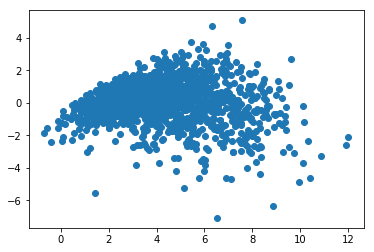

In [42]:
training_predictions = NN_model.predict(X_train)
training = pd.DataFrame(training_predictions)
training['actual'] = y_train.reset_index()['rebounds']
plt.scatter(training_predictions,training[0]-training['actual'])

In [43]:
predictions = NN_model.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [51]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['rebounds']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_rebounding']=X_test['rebounds_ly'].reset_index()['rebounds_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.head()

print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_rebounding'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:1.834668816796147
MSE using mean:6.636280125532765
MSE using last year stats:1.9749925484351714
MSE using LR:1.2238881318726487
MSE using GB:1.186372008796553
MSE using combo:1.2286655233334767


In [48]:
testing.shape

(671, 6)

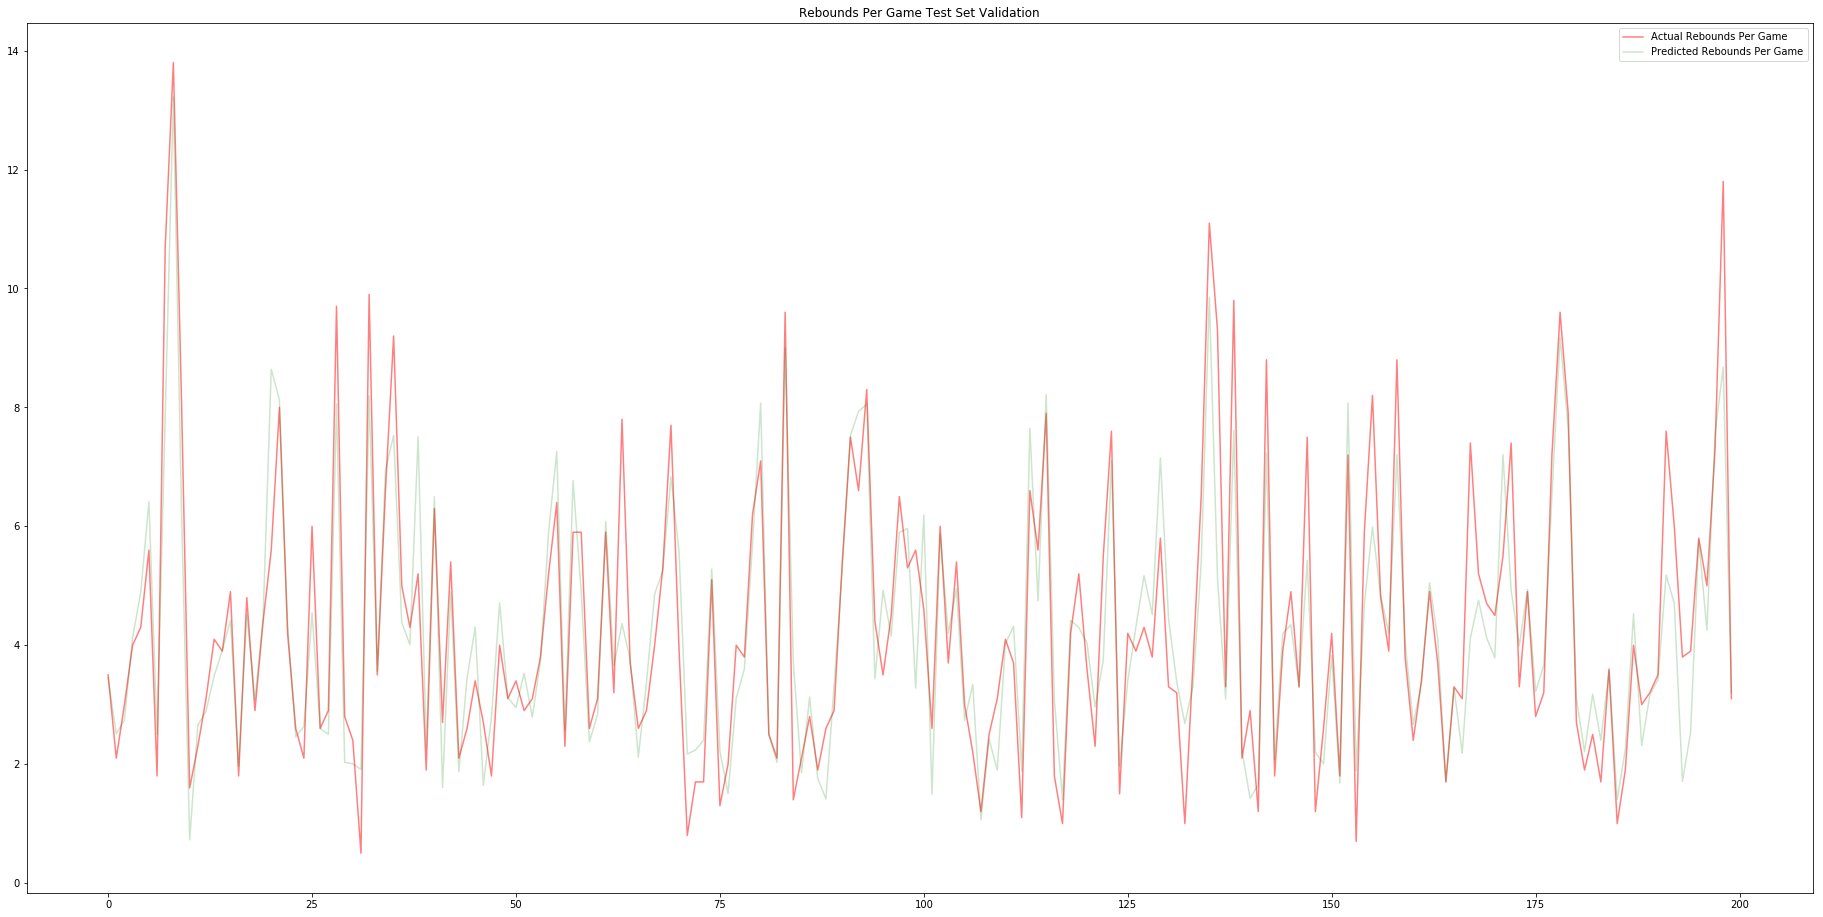

In [50]:
fig,ax = plt.subplots(figsize=(32,16))
plt.plot(testing[0:200].index,testing[0:200]['actual'], color = 'r',alpha = 0.5, label = 'Actual Rebounds Per Game')
plt.plot(testing[0:200].index,testing[0:200]['LR_pred'], color = 'g',alpha = 0.2, label = 'Predicted Rebounds Per Game')
plt.title('Rebounds Per Game Test Set Validation')
plt.legend()
#plt.scatter(testing[0:100].index,testing['LY_rebounding'][0:100],color = 'b',alpha=0.3)

In [52]:
pred_2017rebounds = rebounds[rebounds['season']==2017].drop(['team','player','rebounds','Games'],axis=1)
rebounds_2017 = NN_model.predict(pred_2017rebounds)
test_2 =pd.DataFrame(rebounds_2017)
gbr_reb_2017 = pd.DataFrame(gbr.predict(pred_2017rebounds))
LR_reb_2017 = pd.DataFrame(LR.predict(pred_2017rebounds))
test_3 = pd.merge(rebounds,pred_2017rebounds,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_reb_2017[0]
test_3['LR_pred'] = LR_reb_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','rebounds','rebounds_ly_x','predictions','gbr_pred','LR_pred','mean_pred']].sort_values(by='rebounds_ly_x',ascending=False)[50:100]

rebounds_2017 = test_3[['player','LR_pred','gbr_pred']]
rebounds_2017.columns = ['player','rebound_prediction','rebound_prediction_gbr']
df_2017 = pd.merge(df_2017,rebounds_2017, how='left',left_on='player',right_on='player')
#df_2017.drop(['rebound_prediction_x','rebound_prediction_y'])

In [189]:
pred_2017rebounds

,season,age,rebounds_ly,change_rebounds_ly,C_PF,PG,SG_SF,starter_change,high_usageplayer_added,usagemin_opened,...,defensive_boxplusminus,boxplusminus,value_overreplacement,max_teammatereb,max_teammate_usage,max_teammateto,max_teammateshot_attempts,career_rebounds,yearspro,age_squared
688,2017,23,0.6,-0.1,0,0,1,0,0.0,0.000000,...,-2.1,-11.6,0.0,8.4,897.669620,2.5,16.2,0.680769,2,529
694,2017,27,7.4,1.3,1,0,0,1,0.0,0.000000,...,1.2,-1.1,0.4,8.0,1131.480000,2.6,19.8,5.674423,7,729
742,2017,24,3.1,-0.3,0,0,1,0,0.0,0.000000,...,-2.3,2.2,2.8,10.4,1112.584615,4.1,18.4,3.543210,5,576
754,2017,24,0.6,0.0,0,0,1,0,0.0,0.000000,...,-2.8,-6.0,-0.3,7.8,794.548611,2.1,17.7,0.600000,1,576
759,2017,26,3.6,0.4,0,0,1,0,0.0,0.000000,...,-2.3,1.0,2.1,8.0,1131.480000,2.6,19.8,2.640000,4,676
778,2017,22,1.2,-1.6,1,0,0,0,0.0,0.000000,...,-3.0,-3.8,0.0,10.4,1112.584615,4.1,18.4,2.160000,2,484
803,2017,27,4.9,0.9,0,1,0,0,0.0,0.000000,...,-2.0,4.3,4.3,8.0,961.125000,2.2,18.0,4.004798,5,729
815,2017,30,3.3,-0.5,0,0,1,0,0.0,0.000000,...,2.7,2.4,2.0,7.8,794.548611,2.1,17.7,3.421702,8,900
822,2017,24,0.8,-0.4,0,0,1,0,0.0,0.000000,...,-1.1,-6.1,-0.4,7.8,794.548611,2.1,17.7,0.997403,2,576
824,2017,25,1.5,0.0,1,0,0,0,0.0,0.000000,...,0.6,1.8,0.8,7.8,794.548611,2.1,17.7,1.500000,1,625


In [55]:
print(np.mean((df_2017['rebounds']-df_2017['rebound_prediction'])**2))
print(np.mean((df_2017['rebounds']-df_2017['rebound_prediction_gbr'])**2)) #may choose gbr here.

1.2838105576828076
1.2673714283134176


In [57]:
print('MSE using NN:{}'.format(np.mean((test_3['rebounds']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['rebounds']-np.mean(test_3['rebounds']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['rebounds']-test_3['rebounds_ly_x'])**2)))
print('MSE using gbr:{}'.format(np.mean((test_3['rebounds']-test_3['gbr_pred'])**2)))
print('MSE using LR:{}'.format(np.mean((test_3['rebounds']-test_3['LR_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['rebounds']-test_3['mean_pred'])**2)))

MSE using NN:1.906088930576505
MSE using mean:6.292553316074948
MSE using last year stats:1.808012820512822
MSE using gbr:1.2673714283134174
MSE using LR:1.283810557682808
MSE using combo:1.2913995587182252


In [59]:
np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5),X_train,y_train,cv=5))

0.7919479118358936

In [58]:
np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5))

0.7969944937969184

In [60]:
'''next is assists'''


query= '''
        
        DROP TABLE IF EXISTS assists_pred;
        CREATE TABLE assists_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        ast float, -- these come from player_stats
        ast_ly float,
        change_ast_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        
        -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        assists_opened float,
        max_assistsdropped float,
        max_assistsadded float,
        points_opened float,
        threes_opened float,
        
        -- from player_advstats
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        ast_perc_ly float,
        change_assist_perc float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammateast float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_ast float,
        yearspro int
        );
        
        INSERT INTO assists_pred(season,player,age,team,ast,ast_ly,change_ast_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,ast,ast_ly,change_ast_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update assists_pred ap
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,assists_opened=tc.ast_opened,
        max_assistsdropped=tc.max_astdropped,max_assistsadded=tc.max_astadded,points_opened = tc.points_opened,threes_opened = tc.threes_opened
        from team_changes tc
        where tc.team = ap.team and ap.season=tc.season;
        
        update assists_pred ap
        set per_ly=pa.per_ly,change_per=pa.change_per,usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly
        ,ast_perc_ly = pa.ast_perc_ly,change_assist_perc = pa.change_assist_perc,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where ap.player = pa.player and ap.season = pa.season and ap.team = pa.startingteam;
        
        update assists_pred ap
        set max_teammateast = tm.max_teammateast,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = ap.season and tm.player = ap.player;
        
        update assists_pred ap
        set career_ast = pc.career_ast, yearspro = pc.yearspro
        from player_careerstats pc
        where ap.player = pc.player and ap.season = pc.season;
        
        
        select * from assists_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
assists_df = pd.DataFrame(np.array(data))
assists_df.columns = ['season','player','age','team','assists','assists_ly','change_assists_ly','Games','C_PF','PG','SG_SF','starter_change','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','assists_opened','max_assistsdropped',
                    'max_assistsadded','points_opened','threes_opened','per_ly','change_per','usagerank','usagerank_ly','ast_perc_ly','change_ast_perc','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement'
                      ,'max_teammateast','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_assists','yearspro']

In [61]:
assists_df['age_squared']=assists_df['age']*assists_df['age']
assists = assists_df[assists_df['assists_ly'].notna()]
for i in assists.columns:
    if i not in(['player','team']):
        assists[i]=pd.to_numeric(assists[i])
assists = assists.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [150]:
X = assists[(assists['season']!=2017) & (assists['Games']>30)].drop(['player','team','assists','Games'],axis=1)
y = assists[(assists['season']!=2017) & (assists['Games']>30)]['assists']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [151]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.8365385945872216
0.8340413381493251


In [63]:
NN_ast = Sequential()
NN_ast.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_ast.add(Dense(units=1,activation='linear'))
NN_ast.compile(loss='mse', optimizer='adam')
NN_ast.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=64)

Epoch 1/1000
1564/1564 [==============================] - 0s 269us/step - loss: 61144.1190
Epoch 2/1000
1564/1564 [==============================] - 0s 23us/step - loss: 5189.1772
Epoch 3/1000
1564/1564 [==============================] - 0s 19us/step - loss: 1197.7746
Epoch 4/1000
1564/1564 [==============================] - 0s 16us/step - loss: 550.4240
Epoch 5/1000
1564/1564 [==============================] - 0s 16us/step - loss: 360.5649
Epoch 6/1000
1564/1564 [==============================] - 0s 18us/step - loss: 257.9893
Epoch 7/1000
1564/1564 [==============================] - 0s 20us/step - loss: 191.0676
Epoch 8/1000
1564/1564 [==============================] - 0s 16us/step - loss: 144.7849
Epoch 9/1000
1564/1564 [==============================] - 0s 16us/step - loss: 111.4521
Epoch 10/1000
1564/1564 [==============================] - 0s 16us/step - loss: 89.8558
Epoch 11/1000
1564/1564 [==============================] - 0s 20us/step - loss: 71.0502
Epoch 12/1000
1564/1564 [==

In [70]:
predictions = NN_ast.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

In [72]:
testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['assists']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_assists']=X_test['assists_ly'].reset_index()['assists_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.head()

print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_assists'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:4.246858491558193
MSE using mean:3.619606344157898
MSE using last year stats:0.9543517138599105
MSE using LR:0.6467503321859689
MSE using GB:0.6097039045861677
MSE using combo:1.0124371899556721


In [73]:
pred_2017assists = assists[assists['season']==2017].drop(['team','player','assists','Games'],axis=1)
assists_2017 = NN_ast.predict(pred_2017assists)
gbr_ast_2017 = pd.DataFrame(gbr.predict(pred_2017assists))
LR_ast_2017 = pd.DataFrame(LR.predict(pred_2017assists))
test_2 =pd.DataFrame(assists_2017)
test_3 = pd.merge(assists,pred_2017assists,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_ast_2017[0]
test_3['LR_pred'] = LR_ast_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','assists','predictions','assists_ly_x','gbr_pred','LR_pred','mean_pred']].sort_values(by='assists_ly_x',ascending=False)[0:50]

assists_2017 = test_3[['player','LR_pred','gbr_pred']]
assists_2017.columns = ['player','assist_prediction','assist_prediction_gbr']
df_2017 = pd.merge(df_2017,assists_2017,how='left',left_on='player',right_on='player')

In [74]:
print('MSE using NN:{}'.format(np.mean((test_3['assists']-test_3['predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['assists']-np.mean(test_3['assists']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['assists']-test_3['assists_ly_x'])**2)))
print('MSE using LR:{}'.format(np.mean((test_3['assists']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['assists']-test_3['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['assists']-test_3['mean_pred'])**2)))

MSE using NN:3.3710799158845557
MSE using mean:3.3617587113740988
MSE using last year stats:0.850384615384615
MSE using LR:0.5407713855987187
MSE using GB:0.5300133327493853
MSE using combo:0.7758146758919157


In [75]:
'''next is steals.  In the future, may want to add minutes from last season?'''


query= '''
        
        DROP TABLE IF EXISTS steals_pred;
        CREATE TABLE steals_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        stl float, -- these come from player_stats
        stl_ly float,
        change_stl_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        

        -- from player_advstats
        per_ly float,
        change_per float,
        stl_perc_ly float,
        change_stl_perc_ly float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_stl float,
        yearspro int
        );
        
        INSERT INTO steals_pred(season,player,age,team,stl,stl_ly,change_stl_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,stl,stl_ly,change_stl_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        
        update steals_pred sp
        set per_ly=pa.per_ly,change_per=pa.change_per,stl_perc_ly = pa.stl_perc_ly,change_stl_perc_ly = pa.change_stl_perc_ly
        ,defensive_winshares=pa.defensive_winshares,defensive_boxplusminus=pa.defensive_boxplusminus
        ,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where sp.player = pa.player and sp.season = pa.season and sp.team = pa.startingteam;
        
        update steals_pred sp
        set max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = sp.season and tm.player = sp.player;
        
        update steals_pred sp
        set career_stl = pc.career_stl, yearspro = pc.yearspro
        from player_careerstats pc
        where sp.player = pc.player and sp.season = pc.season;
        
        
        select * from steals_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
steals_df = pd.DataFrame(np.array(data))
steals_df.columns = ['season','player','age','team','steals','steals_ly','change_steals_ly','Games','C_PF','PG','SG_SF','starter_change'
                    ,'per_ly','change_per','stl_perc_ly','change_stl_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement'
                     ,'max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_steals','yearspro']

In [76]:
steals_df['age_squared']=steals_df['age']*steals_df['age']
steals = steals_df[steals_df['steals_ly'].notna()]
for i in steals.columns:
    if i not in(['player','team']):
        steals[i]=pd.to_numeric(steals[i])
steals = steals.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [152]:
X = steals[(steals['season']!=2017) & (steals['Games']>30)].drop(['player','team','steals','Games'],axis=1)
y = steals[(steals['season']!=2017) & (steals['Games']>30)]['steals']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [153]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7148894386403521
0.704376420433202


In [78]:
NN_stl = Sequential()
NN_stl.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_stl.add(Dense(units=1,activation='linear'))
NN_stl.compile(loss='mse', optimizer='adam')
NN_stl.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 0s 263us/step - loss: 171321.0814
Epoch 2/1000
1564/1564 [==============================] - 0s 10us/step - loss: 55167.8488
Epoch 3/1000
1564/1564 [==============================] - 0s 11us/step - loss: 10967.5881
Epoch 4/1000
1564/1564 [==============================] - 0s 12us/step - loss: 700.5201
Epoch 5/1000
1564/1564 [==============================] - 0s 10us/step - loss: 235.2051
Epoch 6/1000
1564/1564 [==============================] - 0s 11us/step - loss: 266.0812
Epoch 7/1000
1564/1564 [==============================] - 0s 10us/step - loss: 91.9871
Epoch 8/1000
1564/1564 [==============================] - 0s 11us/step - loss: 56.5442
Epoch 9/1000
1564/1564 [==============================] - 0s 11us/step - loss: 57.5314
Epoch 10/1000
1564/1564 [==============================] - 0s 11us/step - loss: 53.9916
Epoch 11/1000
1564/1564 [==============================] - 0s 11us/step - loss: 52.4016
Epoch 12/1000
1564/1564 [==

In [80]:
predictions = NN_stl.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['steals']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_steals']=X_test['steals_ly'].reset_index()['steals_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_steals',ascending=False)[50:100]

print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_steals'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:0.07949253988989402
MSE using mean:0.17844474403708313
MSE using last year stats:0.07622950819672118
MSE using LR:0.048974271936013086
MSE using GB:0.04935988875921942
MSE using combo:0.05096337585755196


In [81]:
pred_2017steals = steals[steals['season']==2017].drop(['team','player','steals','Games'],axis=1)
steals_2017 = NN_stl.predict(pred_2017steals)
gbr_stl_2017 = pd.DataFrame(gbr.predict(pred_2017steals))
LR_stl_2017 = pd.DataFrame(LR.predict(pred_2017steals))
test_2 =pd.DataFrame(steals_2017)
test_3 = pd.merge(steals,pred_2017steals,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_stl_2017[0]
test_3['LR_pred'] = LR_stl_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','steals','predictions','LR_pred','gbr_pred','mean_pred','steals_ly_x']].sort_values(by='steals_ly_x',ascending=False)[0:50]

steals_2017 = test_3[['player','LR_pred','gbr_pred']]
steals_2017.columns = ['player','steal_prediction','steal_prediction_gbr']
df_2017 = pd.merge(df_2017,steals_2017, how = 'left',left_on='player',right_on='player')

In [82]:
print('MSE using LR:{}'.format(np.mean((test_3['steals']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['steals']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['steals']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['steals']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['steals']-np.mean(test_3['steals']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['steals']-test_3['steals_ly_x'])**2)))


MSE using LR:0.05644712662490017
MSE using GB:0.05906816426190716
MSE using NN:0.08474671212359779
MSE using combo:0.05995560448940256
MSE using mean:0.17097129766600938
MSE using last year stats:0.08067307692307688


In [401]:
print(gbr.feature_importances_)
X_train.columns

[0.01125328 0.04008531 0.10639288 0.04426043 0.02392808 0.00408012
 0.0016119  0.0723225  0.04320477 0.05824298 0.0763244  0.08581513
 0.04672878 0.07181035 0.06675481 0.04345141 0.15460267 0.01074619
 0.03838401]


Index(['season', 'age', 'steals_ly', 'change_steals_ly', 'C_PF', 'PG', 'SG_SF',
       'starter_change', 'per_ly', 'change_per', 'stl_perc_ly',
       'change_stl_perc', 'defensive_winshares', 'defensive_boxplusminus',
       'boxplusminus', 'value_overreplacement', 'career_steals', 'yearspro',
       'age_squared'],
      dtype='object')

In [83]:
'''next is blocks.  In the future, may want to add minutes from last season?'''


query= '''
        
        DROP TABLE IF EXISTS blocks_pred;
        CREATE TABLE blocks_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        blk float, -- these come from player_stats
        blk_ly float,
        change_blk_ly float,
        Games float,
        C_PF int,
        PG int,
        SG_SF int,
        starter_change int, 
        

        -- from player_advstats
        per_ly float,
        change_per float,
        blk_perc_ly float,
        change_blk_perc_ly float,
        defensive_winshares float,
        defensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_blk float,
        yearspro int
        );
        
        INSERT INTO blocks_pred(season,player,age,team,blk,blk_ly,change_blk_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,blk,blk_ly,change_blk_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        
        update blocks_pred bp
        set per_ly=pa.per_ly,change_per=pa.change_per,blk_perc_ly = pa.blk_perc_ly,change_blk_perc_ly = pa.change_blk_perc_ly
        ,defensive_winshares=pa.defensive_winshares,defensive_boxplusminus=pa.defensive_boxplusminus
        ,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where bp.player = pa.player and bp.season = pa.season and bp.team = pa.startingteam;
        
        update blocks_pred bp
        set max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = bp.season and tm.player = bp.player;
        
        update blocks_pred bp
        set career_blk = pc.career_blk, yearspro = pc.yearspro
        from player_careerstats pc
        where bp.player = pc.player and bp.season = pc.season;
        
        
        select * from blocks_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
blocks_df = pd.DataFrame(np.array(data))
blocks_df.columns = ['season','player','age','team','blocks','blocks_ly','change_blocks_ly','Games','C_PF','PG','SG_SF','starter_change'
                    ,'per_ly','change_per','blk_perc_ly','change_blk_perc','defensive_winshares','defensive_boxplusminus','boxplusminus','value_overreplacement'
                     ,'max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_blocks','yearspro']

In [84]:
blocks_df['age_squared']=blocks_df['age']*blocks_df['age']
blocks = blocks_df[blocks_df['blocks_ly'].notna()]
for i in blocks.columns:
    if i not in(['player','team']):
        blocks[i]=pd.to_numeric(blocks[i])
blocks = blocks.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [154]:
X = blocks[(blocks['season']!=2017) & (blocks['Games']>30)].drop(['player','team','blocks','Games'],axis=1)
#X = blocks[(blocks['season']!=2017) & (blocks['Games']>30)][['blocks_ly','career_blocks','starter_change']]
y = blocks[(blocks['season']!=2017) & (blocks['Games']>30)]['blocks']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [155]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7716459053117181
0.7617947169583775


In [86]:
NN_blk = Sequential()
NN_blk.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_blk.add(Dense(units=1,activation='linear'))
NN_blk.compile(loss='mse', optimizer='adam')
NN_blk.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 0s 233us/step - loss: 7751.7720
Epoch 2/1000
1564/1564 [==============================] - 0s 10us/step - loss: 281.8858
Epoch 3/1000
1564/1564 [==============================] - 0s 9us/step - loss: 28.4075
Epoch 4/1000
1564/1564 [==============================] - 0s 10us/step - loss: 10.3818
Epoch 5/1000
1564/1564 [==============================] - 0s 10us/step - loss: 8.0090
Epoch 6/1000
1564/1564 [==============================] - 0s 10us/step - loss: 6.9980
Epoch 7/1000
1564/1564 [==============================] - 0s 12us/step - loss: 6.4935
Epoch 8/1000
1564/1564 [==============================] - 0s 10us/step - loss: 6.1411
Epoch 9/1000
1564/1564 [==============================] - 0s 11us/step - loss: 5.7782
Epoch 10/1000
1564/1564 [==============================] - 0s 11us/step - loss: 5.4489
Epoch 11/1000
1564/1564 [==============================] - 0s 11us/step - loss: 5.1748
Epoch 12/1000
1564/1564 [====================

In [88]:
predictions = NN_blk.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.3)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['blocks']
testing['gbr_pred']=gbr_predictions
testing['LY_blocks']=X_test['blocks_ly'].reset_index()['blocks_ly']
testing['LR_pred'] = LR.predict(X_test)
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_blocks',ascending=False)[50:100]

print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_blocks'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))



MSE using NN:5.979647096035852
MSE using mean:0.22821542240711085
MSE using last year stats:0.06031296572280168
MSE using LR:0.04728809737614942
MSE using GB:0.04963060212199316
MSE using combo:0.7133087631337942


In [89]:
pred_2017blocks = blocks[blocks['season']==2017].drop(['team','player','blocks','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
blocks_2017 = NN_blk.predict(pred_2017blocks)
gbr_blk_2017 = pd.DataFrame(gbr.predict(pred_2017blocks))
LR_blk_2017 = pd.DataFrame(LR.predict(pred_2017blocks))
test_2 =pd.DataFrame(blocks_2017)
test_3 = pd.merge(blocks,pred_2017blocks,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_blk_2017[0]
test_3['LR_pred'] = LR_blk_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','blocks','predictions','LR_pred','gbr_pred','mean_pred','blocks_ly_x']].sort_values(by='blocks_ly_x',ascending=False)[0:50]

blocks_2017 = test_3[['player','LR_pred']]
blocks_2017.columns=['player','block_predictions']
df_2017=pd.merge(df_2017,blocks_2017,how='left',left_on='player',right_on='player')


In [90]:
print('MSE using LR:{}'.format(np.mean((test_3['blocks']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['blocks']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['blocks']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['blocks']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['blocks']-np.mean(test_3['blocks']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['blocks']-test_3['blocks_ly_x'])**2)))


MSE using LR:0.03700705651300036
MSE using GB:0.04347771232318498
MSE using NN:0.18523935138228456
MSE using combo:0.05092168934393976
MSE using mean:0.18036817882971726
MSE using last year stats:0.04798076923076909


In [91]:
 query= '''
        
        DROP TABLE IF EXISTS threes_pred;
        CREATE TABLE threes_pred(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        threes_made float, -- these come from player_stats
        threes_ly float,
        change_threes float,
        points_ly float,
        change_points_ly float,
        starter_change int,
        C_PF int,
        PG int,
        SG_SF int,
        Games int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_threes float,
        yearspro int
        );
        
        INSERT INTO threes_pred(season,player,age,team,threes_made,threes_ly,change_threes,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF,Games)
        SELECT season,player,age,startingteam,threes_made,threes_ly,change_threes,points_ly,change_points_ly,starter-starter_ly,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end,Games
        from player_stats;
        
        update threes_pred tp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = tp.team and tp.season=tc.season;
        
        update threes_pred tp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where tp.player = pa.player and tp.season = pa.season and tp.team = pa.startingteam;
        
        update threes_pred tp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = tp.season and tm.player = tp.player;
        
        update threes_pred tp
        set career_threes = pc.career_threesmade, yearspro = pc.yearspro
        from player_careerstats pc
        where tp.player = pc.player and tp.season = pc.season;
        
        
        select * from threes_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
threes_df = pd.DataFrame(np.array(data))
threes_df.columns = ['season','player','age','team','3PM','3PM_ly','3PM_change','points_ly','change_points_ly','starter_change','C_PF','PG','SG_SF','Games','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped','points_opened','max_pointsdropped',
                    'max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement'
                     ,'max_teammatepts','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_3PM','yearspro']

In [92]:
threes_df['age_squared']=threes_df['age']*threes_df['age']
threes = threes_df[threes_df['3PM_ly'].notna()]
for i in threes.columns:
    if i not in(['player','team']):
        threes[i]=pd.to_numeric(threes[i])
threes = threes.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [156]:
X = threes[(threes['season']!=2017) & (threes['Games']>30)].drop(['player','team','3PM','Games'],axis=1)
y = threes[(threes['season']!=2017) & (threes['Games']>30)]['3PM']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [157]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7392288593653296
0.7513313283667964


In [94]:
NN_3s = Sequential()
NN_3s.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_3s.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_3s.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_3s.add(Dense(units=1,activation='linear'))
NN_3s.compile(loss='mse', optimizer='adam')
NN_3s.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 0s 285us/step - loss: 5521.7397
Epoch 2/1000
1564/1564 [==============================] - 0s 9us/step - loss: 2189.1801
Epoch 3/1000
1564/1564 [==============================] - 0s 8us/step - loss: 1057.8641
Epoch 4/1000
1564/1564 [==============================] - 0s 9us/step - loss: 749.6639
Epoch 5/1000
1564/1564 [==============================] - 0s 9us/step - loss: 516.6500
Epoch 6/1000
1564/1564 [==============================] - 0s 9us/step - loss: 364.8543
Epoch 7/1000
1564/1564 [==============================] - 0s 9us/step - loss: 288.7420
Epoch 8/1000
1564/1564 [==============================] - 0s 11us/step - loss: 230.9539
Epoch 9/1000
1564/1564 [==============================] - 0s 11us/step - loss: 187.1606
Epoch 10/1000
1564/1564 [==============================] - 0s 10us/step - loss: 156.8740
Epoch 11/1000
1564/1564 [==============================] - 0s 9us/step - loss: 130.7741
Epoch 12/1000
1564/1564 [========

In [95]:
predictions = NN_3s.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['3PM']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_3PM']=X_test['3PM_ly'].reset_index()['3PM_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_3PM',ascending=False)[50:100]

print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_3PM'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:0.18046795409910002
MSE using mean:0.5597797623939207
MSE using last year stats:0.1647540983606564
MSE using LR:0.13398923082687017
MSE using GB:0.1279381347145649
MSE using combo:0.13332190263540417


In [96]:
pred_2017threes = threes[threes['season']==2017].drop(['team','player','3PM','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
threes_2017 = NN_3s.predict(pred_2017threes)
gbr_3PM_2017 = pd.DataFrame(gbr.predict(pred_2017threes))
LR_3PM_2017 = pd.DataFrame(LR.predict(pred_2017threes))
test_2 =pd.DataFrame(threes_2017)
test_3 = pd.merge(threes,pred_2017threes,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_3PM_2017[0]
test_3['LR_pred'] = LR_3PM_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','3PM','predictions','LR_pred','gbr_pred','mean_pred','3PM_ly_x']].sort_values(by='3PM_ly_x',ascending=False)[0:50]

threes_2017 = test_3[['player','LR_pred','gbr_pred']]
threes_2017.columns = ['player','three_prediction','three_prediction_gbr']
df_2017 = pd.merge(df_2017,threes_2017,how='left',left_on='player',right_on='player')

In [97]:
print('MSE using LR:{}'.format(np.mean((test_3['3PM']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['3PM']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['3PM']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['3PM']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['3PM']-np.mean(test_3['3PM']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['3PM']-test_3['3PM_ly_x'])**2)))

MSE using LR:0.16293060539032717
MSE using GB:0.17707480323190966
MSE using NN:0.4743397497661
MSE using combo:0.20751535135834032
MSE using mean:0.7179477933925057
MSE using last year stats:0.20919871794871772


In [98]:
query= '''
        
        DROP TABLE IF EXISTS turnovers_pred;
        CREATE TABLE turnovers_pred(
        season int, -- these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        turnovers float, 
        turnovers_ly float,
        change_tov_ly float,
        starter_change int,
        Games int,
        C_PF int,
        PG int,
        SG_SF int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        career_to float,
        yearspro int
        );
        
        INSERT INTO turnovers_pred(season,player,age,team,turnovers,turnovers_ly,change_tov_ly,starter_change,Games,C_PF,PG,SG_SF)
        SELECT season,player,age,startingteam,tov,tov_ly,change_tov_ly,starter-starter_ly,Games,
        case when pos in ('C','PF') then 1 else 0 end,case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end from player_stats;
        
        update turnovers_pred pp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped
        from team_changes tc
        where tc.team = pp.team and pp.season=tc.season;
        
        update turnovers_pred pp
        set per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus
        from player_advstats pa
        where pp.player = pa.player and pp.season = pa.season and pp.team = pa.startingteam;
        
        update turnovers_pred pp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = pp.season and tm.player = pp.player;
        
        update turnovers_pred pp
        set career_to = pc.career_to, yearspro = pc.yearspro
        from player_careerstats pc
        where pp.player = pc.player and pp.season = pc.season;
        
        
        select * from turnovers_pred where season>2009
        '''


cur.execute(query)
data = cur.fetchall()
to_df = pd.DataFrame(np.array(data))
to_df.columns = ['season','player','age','team','turnovers','turnovers_ly','change_turnovers_ly','starter_change','Games','C_PF','PG','SG_SF','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped'
                    ,'per_ly','change_per','usagerank','usagerank_ly','offensive_winshares','offensive_boxplusminus'
                 ,'max_teammatepts','max_teammate_usage','max_teammateto','max_teammateshot_attempts','career_turnovers','yearspro']

In [99]:
to_df['age_squared']=to_df['age']*to_df['age']
tos = to_df[to_df['turnovers_ly'].notna()]
for i in tos.columns:
    if i not in(['player','team']):
        tos[i]=pd.to_numeric(tos[i])
tos = tos.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [158]:
X = tos[(tos['season']!=2017) & (tos['Games']>30)].drop(['player','team','turnovers','Games'],axis=1)
y = tos[(tos['season']!=2017) & (tos['Games']>30)]['turnovers']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [160]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7473024428858299
0.7445833723495217


In [101]:
NN_tos = Sequential()
NN_tos.add(Dense(units=8,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_tos.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
#NN_tos.add(Dense(units=4, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_tos.add(Dense(units=1,activation='linear'))
NN_tos.compile(loss='mse', optimizer='adam')
NN_tos.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 0s 286us/step - loss: 168754.5790
Epoch 2/1000
1564/1564 [==============================] - 0s 11us/step - loss: 117698.6862
Epoch 3/1000
1564/1564 [==============================] - 0s 9us/step - loss: 82784.1634
Epoch 4/1000
1564/1564 [==============================] - 0s 9us/step - loss: 58176.5714
Epoch 5/1000
1564/1564 [==============================] - 0s 8us/step - loss: 40477.3528
Epoch 6/1000
1564/1564 [==============================] - 0s 8us/step - loss: 27393.3650
Epoch 7/1000
1564/1564 [==============================] - 0s 9us/step - loss: 17489.9350
Epoch 8/1000
1564/1564 [==============================] - 0s 10us/step - loss: 10469.7122
Epoch 9/1000
1564/1564 [==============================] - 0s 12us/step - loss: 6023.7106
Epoch 10/1000
1564/1564 [==============================] - 0s 11us/step - loss: 3487.5293
Epoch 11/1000
1564/1564 [==============================] - 0s 11us/step - loss: 2102.7516
Epoch 12/1000

In [102]:
predictions = NN_tos.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['turnovers']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_turnovers']=X_test['turnovers_ly'].reset_index()['turnovers_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_turnovers',ascending=False)[50:100]


print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_turnovers'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:0.6221030313583455
MSE using mean:0.6160988448408726
MSE using last year stats:0.221266766020865
MSE using LR:0.1411700032512256
MSE using GB:0.13765981981192318
MSE using combo:0.19576075623896946


In [103]:
pred_2017tos = tos[tos['season']==2017].drop(['team','player','turnovers','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
tos_2017 = NN_tos.predict(pred_2017tos)
gbr_tos_2017 = pd.DataFrame(gbr.predict(pred_2017tos))
LR_tos_2017 = pd.DataFrame(LR.predict(pred_2017tos))
test_2 =pd.DataFrame(tos_2017)
test_3 = pd.merge(tos,pred_2017tos,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_tos_2017[0]
test_3['LR_pred'] = LR_tos_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','turnovers','predictions','LR_pred','gbr_pred','mean_pred','turnovers_ly_x']].sort_values(by='turnovers_ly_x',ascending=False)[0:50]

to_2017 = test_3[['player','LR_pred','gbr_pred']]
to_2017.columns = ['player','turnover_prediction','turnover_prediction_gbr']
df_2017 = pd.merge(df_2017,to_2017,how='left',left_on='player',right_on='player')

In [104]:
print('MSE using LR:{}'.format(np.mean((test_3['turnovers']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['turnovers']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['turnovers']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['turnovers']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['turnovers']-np.mean(test_3['turnovers']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['turnovers']-test_3['turnovers_ly_x'])**2)))

MSE using LR:0.1606140000989842
MSE using GB:0.151389813081065
MSE using NN:0.8270302227343814
MSE using combo:0.22806517606687207
MSE using mean:0.6552399737015117
MSE using last year stats:0.21083333333333312


In [105]:
 query= '''
        
        DROP TABLE IF EXISTS percentages;
        CREATE TABLE percentages(
        season int, --these come from player_stats
        player varchar(50),
        Age int,
        team varchar(50),
        FGM float, -- these come from player_stats
        FGA float,
        FG_percent float,
        FG_percent_ly float,
        FGM_ly float,
        FGA_ly float,
        FTM float,
        FTA float,
        FT_percent float,
        FT_percent_ly float,
        FTM_ly float,
        FTA_ly float,
        threes_ly float,
        change_threes float,
        points_ly float,
        change_points_ly float,
        starter_change int,
        C_PF int,
        PG int,
        SG_SF int,
        Games int,
        
         -- these come from team_changes
        high_usageplayer_added int,
        usagemin_opened float,
        maxusage_added float,
        high_usageplayer_dropped int,
        points_opened float,
        max_pointsdropped float,
        max_pointsadded float,
        
        three_ar_ly float, -- from player_advstats
        change_3ar float,
        per_ly float,
        change_per float,
        usagerank float,
        usagerank_ly float,
        offensive_winshares float,
        offensive_boxplusminus float,
        boxplusminus float,
        value_overreplacement float,
        
        max_teammatepts float,
        max_teammate_usage float,
        max_teammateto float,
        max_teammateshot_attempts float,
        
        
        career_FGM float,
        career_FGA float,
        career_FGPercent float,
        career_FTM float,
        career_FTA float,
        career_FTPercent float,
        yearspro int
        );
        
        INSERT INTO percentages(season,player,age,team,FGM,FGA,FG_percent,FG_percent_ly,FGM_ly,FGA_ly,FTM,FTA,FT_percent
        ,FT_percent_ly,FTM_ly,FTA_ly,threes_ly,change_threes,points_ly,change_points_ly,starter_change,C_PF,PG,SG_SF,Games)
        SELECT season,player,age,startingteam,FG,FGA,case when FGA>0 then FG/FGA else 0 end as FG_percent,
        case when fga_ly>0 then fg_ly/fga_ly else 0 end as FG_percent_ly,FG_ly,fga_ly,FTM,FTA,
        case when FTA>0 then FTM/FTA else 0 end, case when fta_ly>0 then FTM_ly/FTA_ly else 0 end, FTM_ly,FTA_ly,
        threes_ly,change_threes,points_ly,change_points_ly,starter-starter_ly,case when pos in ('C','PF') then 1 else 0 end,
        case when pos='PG' then 1 else 0 end,case when pos in('SG','SF') then 1 else 0 end,Games
        from player_stats;
        
        update percentages tp
        set high_usageplayer_added = tc.high_usageplayer_added,usagemin_opened=tc.usagemin_opened,
        maxusage_added=tc.max_usageadded,high_usageplayer_dropped=tc.high_usageplayer_dropped,points_opened=tc.points_opened,
        max_pointsdropped=tc.max_pointsdropped,max_pointsadded=tc.max_pointsadded
        from team_changes tc
        where tc.team = tp.team and tp.season=tc.season;
        
        update percentages tp
        set three_ar_ly = pa.threear_ly,change_3ar=pa.change_3ar,per_ly=pa.per_ly,change_per=pa.change_per,
        usagerank=pa.usagerank,usagerank_ly=pa.usagerank_ly,offensive_winshares=pa.offensive_winshares,
        offensive_boxplusminus=pa.offensive_boxplusminus,boxplusminus=pa.boxplusminus,value_overreplacement=pa.value_overreplacement
        from player_advstats pa
        where tp.player = pa.player and tp.season = pa.season and tp.team = pa.startingteam;
        
        update percentages tp
        set max_teammatepts = tm.max_teammatepts,max_teammate_usage=tm.max_teammate_usage,max_teammateto=tm.max_teammateto,
        max_teammateshot_attempts=tm.max_teammateshot_attempts
        from teammate_maxes tm
        where tm.season = tp.season and tm.player = tp.player;
        
        update percentages tp
        set career_fgm = pc.career_fgm,career_fga = pc.career_fga,career_FGpercent = case when pc.career_FGA>0 then pc.career_FGM/pc.career_FGA else 0 end,
        career_FTM = pc.career_FTM,career_FTA = pc.career_FTA,career_FTPercent = case when pc.career_FTA>0 then pc.career_FTM/pc.career_FTA else 0 end,yearspro = pc.yearspro
        from player_careerstats pc
        where tp.player = pc.player and tp.season = pc.season;
        
        
        select * from percentages where season>2009
        '''

cur.execute(query)
data = cur.fetchall()
percentages_df = pd.DataFrame(np.array(data))
percentages_df.columns = ['season','player','age','team','FGM','FGA','FG_percent','FG_percent_ly','FGM_ly','FGA_ly','FTM','FTA',
                     'FT_percent','FT_percent_ly','FTM_ly','FTA_ly','3PM_ly','3PM_change','points_ly','change_points_ly','starter_change'
                     ,'C_PF','PG','SG_SF','Games','high_usageplayer_added','usagemin_opened','maxusage_added','high_usageplayer_dropped'
                     ,'points_opened','max_pointsdropped','max_pointsadded','three_ar_ly','change_3ar','per_ly','change_per','usagerank','usagerank_ly'
                     ,'offensive_winshares','offensive_boxplusminus','boxplusminus','value_overreplacement'
                    ,'max_teammatepts','max_teammate_usage','max_teammateto','max_teammateshot_attempts'
                    ,'career_FGM','career_FGA','career_FGpercent','career_FTM','career_FTA','career_FTPercent','yearspro']

In [114]:
percentages_df['age_squared']=percentages_df['age']*percentages_df['age']
percentages_df['yearspro_squared']=percentages_df['yearspro']*percentages_df['yearspro']
percentages = percentages_df[percentages_df['FGM_ly'].notna()]
for i in percentages.columns:
    if i not in(['player','team']):
        percentages[i]=pd.to_numeric(percentages[i])
percentages = percentages.fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [161]:
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FGM']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [162]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7780816657053765
0.7886020828058727


In [116]:
NN_FGM = Sequential()
NN_FGM.add(Dense(units=32,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGM.add(Dense(units=16, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGM.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGM.add(Dense(units=1,activation='linear'))
NN_FGM.compile(loss='mse', optimizer='adam')
NN_FGM.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 1s 381us/step - loss: 35777.5793
Epoch 2/1000
1564/1564 [==============================] - 0s 12us/step - loss: 2865.9388
Epoch 3/1000
1564/1564 [==============================] - 0s 10us/step - loss: 722.1817
Epoch 4/1000
1564/1564 [==============================] - 0s 10us/step - loss: 355.7009
Epoch 5/1000
1564/1564 [==============================] - 0s 9us/step - loss: 229.7265
Epoch 6/1000
1564/1564 [==============================] - 0s 10us/step - loss: 154.9870
Epoch 7/1000
1564/1564 [==============================] - 0s 10us/step - loss: 121.8297
Epoch 8/1000
1564/1564 [==============================] - 0s 10us/step - loss: 107.6244
Epoch 9/1000
1564/1564 [==============================] - 0s 13us/step - loss: 98.0516
Epoch 10/1000
1564/1564 [==============================] - 0s 11us/step - loss: 89.5838
Epoch 11/1000
1564/1564 [==============================] - 0s 11us/step - loss: 81.6908
Epoch 12/1000
1564/1564 [=====

In [117]:
predictions = NN_FGM.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FGM']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_FGM']=X_test['FGM_ly'].reset_index()['FGM_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_FGM',ascending=False)[50:100]



print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_FGM'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:2.5066045029193216
MSE using mean:4.157999204870277
MSE using last year stats:1.5139344262295082
MSE using LR:0.9369655696866572
MSE using GB:0.8660409091379297
MSE using combo:1.0742386792417558


In [120]:
pred_2017FGM = percentages[percentages['season']==2017].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FGM_2017 = NN_FGM.predict(pred_2017FGM)
gbr_FGM_2017 = pd.DataFrame(gbr.predict(pred_2017FGM))
LR_FGM_2017 = pd.DataFrame(LR.predict(pred_2017FGM))
test_2 =pd.DataFrame(FGM_2017)
test_3 = pd.merge(percentages,pred_2017FGM,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FGM_2017[0]
test_3['LR_pred'] = LR_FGM_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FGM','predictions','LR_pred','gbr_pred','mean_pred','FGM_ly_x']].sort_values(by='FGM_ly_x',ascending=False)[0:50]

FGM_2017 = test_3[['player','LR_pred','gbr_pred']]
FGM_2017.columns = ['player','FGM_prediction','FGM_prediction_gbr']
df_2017 = pd.merge(df_2017,FGM_2017, how='left',left_on='player',right_on='player')


In [122]:
print('MSE using LR:{}'.format(np.mean((test_3['FGM']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FGM']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FGM']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FGM']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FGM']-np.mean(test_3['FGM']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FGM']-test_3['FGM_ly_x'])**2)))

MSE using LR:0.9821636691073048
MSE using GB:0.9345124219717775
MSE using NN:1.6009950858508188
MSE using combo:0.996591951388233
MSE using mean:4.272263313609467
MSE using last year stats:1.5276602564102564


In [112]:
percentages.columns

Index(['season', 'player', 'age', 'team', 'FGM', 'FGA', 'FG_percent',
       'FG_percent_ly', 'FGM_ly', 'FGA_ly', 'FTM', 'FTA', 'FT_percent',
       'FT_percent_ly', 'FTM_ly', 'FTA_ly', '3PM_ly', '3PM_change',
       'points_ly', 'change_points_ly', 'starter_change', 'C_PF', 'PG',
       'SG_SF', 'Games', 'high_usageplayer_added', 'usagemin_opened',
       'maxusage_added', 'high_usageplayer_dropped', 'points_opened',
       'max_pointsdropped', 'max_pointsadded', 'three_ar_ly', 'change_3ar',
       'per_ly', 'change_per', 'usagerank', 'usagerank_ly',
       'offensive_winshares', 'offensive_boxplusminus', 'boxplusminus',
       'value_overreplacement', 'max_teammatepts', 'max_teammate_usage',
       'max_teammateto', 'max_teammateshot_attempts', 'career_FGM',
       'career_FGA', 'career_FGpercent', 'career_FTM', 'career_FTA',
       'career_FTPercent', 'yearspro', 'age_squared'],
      dtype='object')

In [163]:
#X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)][['FG_percent_ly','career_FGpercent','age','age_squared','yearspro','yearspro_squared','max_teammateto','max_teammateshot_attempts','max_teammate_usage','max_teammatepts','usagerank']]
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FG_percent']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [164]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.4442309703137942
0.509298485422939


In [124]:
NN_FGP = Sequential()
NN_FGP.add(Dense(units=4,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGP.add(Dense(units=2, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
#NN_FGP.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FGP.add(Dense(units=1,activation='linear'))
NN_FGP.compile(loss='mse', optimizer='adam')
NN_FGP.fit(np.array(X_train), np.array(y_train), epochs=100,batch_size=64)


Epoch 1/100
1564/1564 [==============================] - 0s 317us/step - loss: 219453.4363
Epoch 2/100
1564/1564 [==============================] - 0s 20us/step - loss: 159149.9904
Epoch 3/100
1564/1564 [==============================] - 0s 18us/step - loss: 118156.2599
Epoch 4/100
1564/1564 [==============================] - 0s 17us/step - loss: 90114.6452
Epoch 5/100
1564/1564 [==============================] - 0s 22us/step - loss: 70315.4096
Epoch 6/100
1564/1564 [==============================] - 0s 18us/step - loss: 55916.6300
Epoch 7/100
1564/1564 [==============================] - 0s 17us/step - loss: 45253.1842
Epoch 8/100
1564/1564 [==============================] - 0s 16us/step - loss: 37151.1508
Epoch 9/100
1564/1564 [==============================] - 0s 21us/step - loss: 30838.2774
Epoch 10/100
1564/1564 [==============================] - 0s 17us/step - loss: 25880.7638
Epoch 11/100
1564/1564 [==============================] - 0s 16us/step - loss: 21930.9633
Epoch 12/100
15

In [125]:
predictions = NN_FGP.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FG_percent']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_FGP']=X_test['FG_percent_ly'].reset_index()['FG_percent_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_FGP',ascending=False)[50:100]


print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_FGP'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:2.0085876269459515
MSE using mean:0.00415649230371203
MSE using last year stats:0.0032334242889317136
MSE using LR:0.0024017433755291312
MSE using GB:0.002077531680979484
MSE using combo:0.22454121747827266


In [127]:
pred_2017FGP = percentages[percentages['season']==2017][['FG_percent_ly','career_FGpercent','age','age_squared','yearspro','yearspro_squared','max_teammateto','max_teammateshot_attempts','max_teammate_usage','max_teammatepts','usagerank']]
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FGP_2017 = NN_FGP.predict(pred_2017FGP)
gbr_FGP_2017 = pd.DataFrame(gbr.predict(pred_2017FGP))
LR_FGP_2017 = pd.DataFrame(LR.predict(pred_2017FGP))
test_2 =pd.DataFrame(FGP_2017)
test_3 = pd.merge(percentages,pred_2017FGP,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FGP_2017[0]
test_3['LR_pred'] = LR_FGP_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FG_percent','predictions','LR_pred','gbr_pred','mean_pred','FG_percent_ly_x']].sort_values(by='FG_percent_ly_x',ascending=False)[0:50]

FGP_2017 = test_3[['player','LR_pred','gbr_pred']]
FGP_2017.columns = ['player','FGP_prediction','FGP_prediction_gbr']
df_2017 = pd.merge(df_2017,FGP_2017,how='left',left_on='player',right_on='player')


In [129]:
df_2017['FGA_prediction']=df_2017['FGM_prediction']/df_2017['FGP_prediction']
df_2017['FGA_prediction_gbr']=df_2017['FGM_prediction_gbr']/df_2017['FGP_prediction_gbr']
df_2017

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,three_prediction,three_prediction_gbr,turnover_prediction,turnover_prediction_gbr,FGM_prediction,FGM_prediction_gbr,FGP_prediction,FGP_prediction_gbr,FGA_prediction,FGA_prediction_gbr
0,2017,LeBron James,PF,33,CLE,82,82,36.9,27.5,8.6,...,1.589403,1.802178,3.485041,3.785634,9.527946,8.852119,0.510504,0.535861,18.663798,16.519440
1,2017,Khris Middleton,SF,26,MIL,82,82,36.4,20.1,5.2,...,1.495707,1.477509,1.744583,1.660123,4.998422,5.011572,0.450726,0.433204,11.089702,11.568607
2,2017,Andrew Wiggins,SF,22,MIN,82,82,36.3,17.7,4.4,...,1.095588,1.162359,2.140582,2.208101,7.329020,7.140582,0.454866,0.454134,16.112478,15.723529
3,2017,Bradley Beal,SG,24,WAS,82,82,36.3,22.6,4.4,...,2.581389,2.950568,2.023514,2.098728,7.265317,8.159861,0.457592,0.451667,15.877278,18.066106
4,2017,CJ McCollum,SG,26,POR,81,81,36.1,21.4,4.0,...,2.207229,2.071322,2.061280,2.130762,7.400082,7.849283,0.458345,0.446312,16.145224,17.586996
5,2017,Jrue Holiday,SG,27,NOP,81,81,36.1,19.0,4.5,...,1.366266,1.663811,2.166427,2.259561,5.345653,5.528538,0.458089,0.440920,11.669470,12.538632
6,2017,Karl-Anthony Towns,C,22,MIN,82,82,35.6,21.3,12.3,...,1.140655,1.293798,2.616188,2.589910,9.726565,8.856378,0.525849,0.544347,18.496861,16.269716
7,2017,Russell Westbrook,PG,29,OKC,80,80,36.4,25.4,10.1,...,2.340100,2.426268,4.304961,4.140357,9.624733,7.968016,0.447237,0.418900,21.520453,19.021295
8,2017,Paul George,SF,27,OKC,79,79,36.6,21.9,5.7,...,2.397734,2.620941,2.338373,2.379774,7.025537,7.677768,0.448784,0.403360,15.654619,19.034507
9,2017,Giannis Antetokounmpo,PF,23,MIL,75,75,36.7,26.9,10.0,...,0.892554,0.851071,2.720324,2.656106,8.345047,8.126126,0.492503,0.510108,16.944151,15.930222


In [130]:
print('MSE using LR:{}'.format(np.mean((test_3['FG_percent']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FG_percent']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FG_percent']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FG_percent']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FG_percent']-np.mean(test_3['FG_percent']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FG_percent']-test_3['FG_percent_ly_x'])**2)))

MSE using LR:0.002143970614078335
MSE using GB:0.0021938478553158126
MSE using NN:2.5222400615268348
MSE using combo:0.28200620698980305
MSE using mean:0.004468180392374211
MSE using last year stats:0.0029957528880071352


In [165]:
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FTM']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [166]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.7911069404317881
0.8036427536050212


In [132]:
NN_FTM = Sequential()
NN_FTM.add(Dense(units=32,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTM.add(Dense(units=16, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTM.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTM.add(Dense(units=1,activation='linear'))
NN_FTM.compile(loss='mse', optimizer='adam')
NN_FTM.fit(np.array(X_train), np.array(y_train), epochs=1000,batch_size=128)

Epoch 1/1000
1564/1564 [==============================] - 1s 357us/step - loss: 8486.2002
Epoch 2/1000
1564/1564 [==============================] - 0s 10us/step - loss: 1542.1816
Epoch 3/1000
1564/1564 [==============================] - 0s 10us/step - loss: 373.2810
Epoch 4/1000
1564/1564 [==============================] - 0s 10us/step - loss: 323.4333
Epoch 5/1000
1564/1564 [==============================] - 0s 11us/step - loss: 248.7232
Epoch 6/1000
1564/1564 [==============================] - 0s 11us/step - loss: 208.3392
Epoch 7/1000
1564/1564 [==============================] - 0s 11us/step - loss: 183.8338
Epoch 8/1000
1564/1564 [==============================] - 0s 14us/step - loss: 161.2333
Epoch 9/1000
1564/1564 [==============================] - 0s 14us/step - loss: 131.1755
Epoch 10/1000
1564/1564 [==============================] - 0s 11us/step - loss: 99.5541
Epoch 11/1000
1564/1564 [==============================] - 0s 11us/step - loss: 78.5820
Epoch 12/1000
1564/1564 [====

In [133]:
predictions = NN_FTM.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FTM']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_FTM']=X_test['FTM_ly'].reset_index()['FTM_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_FTM',ascending=False)[50:100]



print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_FTM'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:0.6549485937718288
MSE using mean:2.025983240086976
MSE using last year stats:0.5623099850968708
MSE using LR:0.4189050168439379
MSE using GB:0.3817218522954749
MSE using combo:0.41648037443506686


In [134]:
pred_2017FTM = percentages[percentages['season']==2017].drop(['player','team','FGM','FGA','FG_percent','FTM','FTA','Games'],axis=1)
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FTM_2017 = NN_FTM.predict(pred_2017FTM)
gbr_FTM_2017 = pd.DataFrame(gbr.predict(pred_2017FTM))
LR_FTM_2017 = pd.DataFrame(LR.predict(pred_2017FTM))
test_2 =pd.DataFrame(FTM_2017)
test_3 = pd.merge(percentages,pred_2017FTM,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FTM_2017[0]
test_3['LR_pred'] = LR_FTM_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FTM','predictions','LR_pred','gbr_pred','mean_pred','FTM_ly_x']].sort_values(by='FTM_ly_x',ascending=False)[0:50]

FTM_2017 = test_3[['player','LR_pred','gbr_pred']]
FTM_2017.columns=['player','FTM_predictions','FTM_predictions_gbr']
df_2017 = pd.merge(df_2017,FTM_2017,how='left',left_on='player',right_on='player')

In [135]:
print('MSE using LR:{}'.format(np.mean((test_3['FTM']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FTM']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FTM']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FTM']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FTM']-np.mean(test_3['FTM']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FTM']-test_3['FTM_ly_x'])**2)))

MSE using LR:0.42096887018116375
MSE using GB:0.3968235012903225
MSE using NN:0.7899940668870817
MSE using combo:0.3950797064306724
MSE using mean:1.8538198553583174
MSE using last year stats:0.6499358974358975


In [167]:
X = percentages[(percentages['season']!=2017) & (percentages['Games']>30)][['FT_percent_ly','career_FTPercent','age','age_squared','yearspro','yearspro_squared','max_teammateto','max_teammateshot_attempts','max_teammate_usage','max_teammatepts','usagerank']]
y = percentages[(percentages['season']!=2017) & (percentages['Games']>30)]['FT_percent']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [168]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.29550121134110274
0.41029906940060795


In [137]:
NN_FTP = Sequential()
NN_FTP.add(Dense(units=16,input_dim=X_train.shape[1],activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTP.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
#NN_FTP.add(Dense(units=8, activation='relu'))
#NN_model.add(Dropout(rate=0.5))
NN_FTP.add(Dense(units=1,activation='linear'))
NN_FTP.compile(loss='mse', optimizer='adam')
NN_FTP.fit(np.array(X_train), np.array(y_train), epochs=250,batch_size=64)

Epoch 1/250
1564/1564 [==============================] - 1s 376us/step - loss: 3668.3168
Epoch 2/250
1564/1564 [==============================] - 0s 31us/step - loss: 159.2475
Epoch 3/250
1564/1564 [==============================] - 0s 23us/step - loss: 85.1790
Epoch 4/250
1564/1564 [==============================] - 0s 33us/step - loss: 46.2668
Epoch 5/250
1564/1564 [==============================] - 0s 30us/step - loss: 29.0051
Epoch 6/250
1564/1564 [==============================] - 0s 23us/step - loss: 18.8144
Epoch 7/250
1564/1564 [==============================] - 0s 22us/step - loss: 12.0105
Epoch 8/250
1564/1564 [==============================] - 0s 22us/step - loss: 7.4688
Epoch 9/250
1564/1564 [==============================] - 0s 25us/step - loss: 4.5871
Epoch 10/250
1564/1564 [==============================] - 0s 22us/step - loss: 2.8394
Epoch 11/250
1564/1564 [==============================] - 0s 24us/step - loss: 1.8175
Epoch 12/250
1564/1564 [============================

In [138]:
predictions = NN_FTP.predict(X_test)
gbr = GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth = 3,max_features=0.5)
gbr.fit(X_train,y_train)
gbr_predictions = gbr.predict(X_test)
LR = LinearRegression(fit_intercept=True).fit(X_train,y_train)

testing = pd.DataFrame(predictions)
testing.columns=['NN_predictions']
testing['actual'] = y_test.reset_index()['FT_percent']
testing['gbr_pred']=gbr_predictions
testing['LR_pred'] = LR.predict(X_test)
testing['LY_FT_percent']=X_test['FT_percent_ly'].reset_index()['FT_percent_ly']
testing['mean_pred']= (testing['gbr_pred']+testing['LR_pred']+testing['NN_predictions'])/3
testing.sort_values(by='LY_FT_percent',ascending=False)[50:100]


print('MSE using NN:{}'.format(np.mean((testing['actual']-testing['NN_predictions'])**2)))
print('MSE using mean:{}'.format(np.mean((testing['actual']-np.mean(testing['actual']))**2)))
print('MSE using last year stats:{}'.format(np.mean((testing['actual']-testing['LY_FT_percent'])**2)))
print('MSE using LR:{}'.format(np.mean((testing['actual']-testing['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((testing['actual']-testing['gbr_pred'])**2)))
print('MSE using combo:{}'.format(np.mean((testing['actual']-testing['mean_pred'])**2)))

MSE using NN:0.050636312596758375
MSE using mean:0.015744969208627675
MSE using last year stats:0.0221196808741765
MSE using LR:0.013205454828342277
MSE using GB:0.010422488187475657
MSE using combo:0.014298589333461285


In [145]:
print(np.mean(cross_val_score(LinearRegression(),X_train,y_train,cv=5)))
print(np.mean(cross_val_score(GradientBoostingRegressor(learning_rate=0.01,n_estimators=1000,max_depth=3,max_features=0.5),X_train,y_train,cv=5)))

0.3386448603357553
0.40050738641324857


In [140]:
pred_2017FTP = percentages[percentages['season']==2017][['FT_percent_ly','career_FTPercent','age','age_squared','yearspro','yearspro_squared','max_teammateto','max_teammateshot_attempts','max_teammate_usage','max_teammatepts','usagerank']]
#pred_2017blocks = blocks[blocks['season']==2017][['blocks_ly','career_blocks','starter_change']]
FTP_2017 = NN_FTP.predict(pred_2017FTP)
gbr_FTP_2017 = pd.DataFrame(gbr.predict(pred_2017FTP))
LR_FTP_2017 = pd.DataFrame(LR.predict(pred_2017FTP))
test_2 =pd.DataFrame(FTP_2017)
test_3 = pd.merge(percentages,pred_2017FTP,left_index=True,right_index=True).reset_index()
test_3['predictions']=test_2[0]
test_3['gbr_pred'] = gbr_FTP_2017[0]
test_3['LR_pred'] = LR_FTP_2017[0]
test_3['mean_pred'] = (test_3['predictions']+test_3['gbr_pred']+test_3['LR_pred'])/3
test_3 = test_3[test_3['Games']>30]
test_3[['player','FT_percent','predictions','LR_pred','gbr_pred','mean_pred','FT_percent_ly_x']].sort_values(by='FT_percent_ly_x',ascending=False)[0:50]

FTP_2017 = test_3[['player','LR_pred','gbr_pred']]
FTP_2017.columns=['player','FTP_prediction','FTP_prediction_gbr']
df_2017 = pd.merge(df_2017,FTP_2017,how='left',left_on='player',right_on='player')

In [141]:
df_2017['FTA_prediction'] = df_2017['FTM_predictions']/df_2017['FTP_prediction']
df_2017['FTA_prediction_gbr'] = df_2017['FTM_predictions_gbr']/df_2017['FTP_prediction_gbr']

In [142]:
print('MSE using LR:{}'.format(np.mean((test_3['FT_percent']-test_3['LR_pred'])**2)))
print('MSE using GB:{}'.format(np.mean((test_3['FT_percent']-test_3['gbr_pred'])**2)))
print('MSE using NN:{}'.format(np.mean((test_3['FT_percent']-test_3['predictions'])**2)))
print('MSE using combo:{}'.format(np.mean((test_3['FT_percent']-test_3['mean_pred'])**2)))
print('MSE using mean:{}'.format(np.mean((test_3['FT_percent']-np.mean(test_3['FT_percent']))**2)))
print('MSE using last year stats:{}'.format(np.mean((test_3['FT_percent']-test_3['FT_percent_ly_x'])**2)))

MSE using LR:0.007073569137934941
MSE using GB:0.008510882829181941
MSE using NN:0.09216314108324797
MSE using combo:0.01727357335055907
MSE using mean:0.01222042469995546
MSE using last year stats:0.010477334604603162


In [ ]:
cur.close()
conn.close

In [1014]:
df_2017.columns

Index(['season', 'player', 'position', 'age', 'team', 'gamesPlayed',
       'gamesStarted', 'minutes', 'points', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'threes_made', 'FGM', 'FGA', 'FTM', 'FTA',
       'starter', 'min_rank', 'point_prediction1', 'rebound_prediction',
       'assist_prediction', 'steal_prediction', 'block_predictions',
       'three_prediction', 'turnover_prediction', 'FGM_prediction',
       'FGP_prediction', 'FGA_prediction', 'FTM_predictions', 'FTP_prediction',
       'FTA_prediction'],
      dtype='object')

In [143]:
df_2017['point_prediction2'] = (df_2017['FGM_prediction']*2)+df_2017['FTM_predictions']+df_2017['three_prediction']
df_2017['point_prediction2_gbr'] = (df_2017['FGM_prediction_gbr']*2)+df_2017['FTM_predictions_gbr']+df_2017['three_prediction_gbr']

In [169]:
prediction_ranker = df_2017[df_2017['point_prediction2'].notna()][['season','player','point_prediction2_gbr','rebound_prediction_gbr','assist_prediction','steal_prediction','block_predictions','turnover_prediction','three_prediction','FGM_prediction_gbr','FGA_prediction_gbr','FTM_predictions_gbr','FTA_prediction_gbr','min_rank']]
prediction_ranker.columns=['season','player','points','rebounds','assists','steals','blocks','turnovers','threes_made','FGM','FGA','FTM','FTA','min_rank']

In [170]:
test_2017 = Player_ranker(prediction_ranker)

In [171]:
test_2017.get_category_dist()
test_2017.assign_values()

In [172]:
prediction_ranker2 = test_2017.value.sort_values(by='value_tot',ascending=False).reset_index(drop=True).reset_index()
prediction_ranker2['predicted_rank'] = prediction_ranker2['index']+1
prediction_ranker2.drop('index',axis=1,inplace=True)

In [173]:
prediction_ranker[0:50]

,season,player,points,rebounds,assists,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,min_rank
0,2017,LeBron James,24.515625,7.457374,7.735490,1.344491,0.608670,3.485041,1.589403,8.852119,16.519440,5.009208,6.916344,1
1,2017,Khris Middleton,14.337635,3.733560,2.710447,1.217275,0.189133,1.744583,1.495707,5.011572,11.568607,2.836982,3.288508,2
2,2017,Andrew Wiggins,19.978855,3.706718,1.979041,0.964882,0.457917,2.140582,1.095588,7.140582,15.723529,4.535330,5.932138,3
3,2017,Bradley Beal,22.543829,3.292672,3.337598,1.073347,0.300584,2.023514,2.581389,8.159861,18.066106,3.273538,4.029231,4
4,2017,CJ McCollum,21.365472,3.114888,3.479252,0.926002,0.397254,2.061280,2.207229,7.849283,17.586996,3.595584,4.353923,5
5,2017,Jrue Holiday,14.274513,3.713726,5.552870,1.348152,0.557369,2.166427,1.366266,5.528538,12.538632,1.553627,1.965178,6
6,2017,Karl-Anthony Towns,24.255918,10.880847,3.078279,0.911821,1.312992,2.616188,1.140655,8.856378,16.269716,5.249366,6.485127,7
7,2017,Russell Westbrook,23.756371,8.529296,10.417216,1.893287,0.406266,4.304961,2.340100,7.968016,19.021295,5.394071,6.698264,8
8,2017,Paul George,22.770669,6.759570,3.200395,1.476786,0.397387,2.338373,2.397734,7.677768,19.034507,4.794192,6.078521,9
9,2017,Giannis Antetokounmpo,22.989917,8.103283,5.177670,1.473906,1.597692,2.720324,0.892554,8.126126,15.930222,5.886594,7.603141,10


In [174]:
actual_ranker = rank_2017.value.sort_values(by='value_tot',ascending=False).reset_index(drop=True).reset_index()
actual_ranker['rank'] = actual_ranker['index']+1
actual_ranker.drop('index',axis=1,inplace=True)

In [175]:
compare_predictions = pd.merge(prediction_ranker2,rank_2017.value,how='inner',left_on='player',right_on='player')
compare_predictions = compare_predictions.sort_values(by='value_tot_y',ascending=False).reset_index(drop=True).reset_index()
compare_predictions['rank'] = compare_predictions['index']+1
compare_predictions.drop('index',axis=1,inplace=True)

In [176]:
rank_preds = compare_predictions[['player','rank','predicted_rank','value_tot_x','value_tot_y']][0:200]

yahoo_ranks = pd.read_csv('../Yahoo 2017 Ranks.csv', encoding = "ISO-8859-1", engine='python')


In [177]:
yahoo_ranks['PLAYER']=yahoo_ranks['PLAYER'].str.replace('Ê','')


In [178]:
rank_2017.value.sort_values(by='value_tot',ascending=False)

,season,player,value_tot,value_points,value_rebounds,value_assists,value_blocks,value_steals,value_turnovers,value_threes,value_fg,value_ft
11,2017,Anthony Davis,13.069292,2.728406,2.327843,-0.323373,4.382346,1.403769,-0.642579,-0.719758,2.572502,1.340136
161,2017,Stephen Curry,10.977767,2.415188,0.001938,1.610250,-0.769567,1.647478,-1.635937,3.343394,1.073741,3.291282
47,2017,Kevin Durant,10.555627,2.415188,0.660945,1.254056,2.665042,-0.545910,-1.635937,1.369863,1.809299,2.563082
27,2017,James Harden,10.522310,3.152171,0.118234,2.984140,0.303748,2.134898,-3.374314,2.762944,-0.589500,3.029989
6,2017,Karl-Anthony Towns,9.046572,1.475533,2.793024,-0.272488,1.806390,-0.302200,-0.270069,0.208962,2.213129,1.394291
0,2017,LeBron James,8.050018,2.617858,1.358716,3.136795,0.733074,1.160059,-3.125975,0.557232,2.935558,-1.323300
9,2017,Giannis Antetokounmpo,7.982516,2.507311,1.901427,0.948747,1.806390,1.403769,-1.635937,-0.835849,2.328774,-0.442116
17,2017,Damian Lillard,7.758411,2.507311,-0.230652,1.864674,-0.340241,0.428929,-1.387598,2.066403,-0.920536,3.770119
120,2017,Chris Paul,7.259998,0.978069,0.118234,2.526177,-0.769567,1.891188,-0.642579,1.369863,-0.176916,1.965529
68,2017,Jimmy Butler,7.194467,1.641355,0.079468,0.999632,-0.340241,2.622318,-0.145900,-0.139308,0.324360,2.152782


In [179]:
yahoo_ranks['PLAYER']=yahoo_ranks['PLAYER'].str.replace('Ê','')
yahoo_ranks['PLAYER']=yahoo_ranks['PLAYER'].str.replace(' Jr.','')
yahoo_ranks.head()

,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,1,Kevin Durant,GSW,1.0,1.0,5.0
1,2,Russell Westbrook,OKC,2.0,5.0,1.0
2,3,James Harden,HOU,6.0,2.0,3.0
3,4,Stephen Curry,GSW,3.0,6.0,4.0
4,5,Giannis Antetokounmpo,MIL,9.0,3.0,2.0


In [180]:
all_ranks = pd.merge(rank_preds,yahoo_ranks,how='left',left_on='player',right_on='PLAYER')

all_ranks[0:50]

,player,rank,predicted_rank,value_tot_x,value_tot_y,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,Anthony Davis,1,3,10.251749,13.069292,7.0,Anthony Davis,NOR,4.0,8.0,7.0
1,Stephen Curry,2,2,10.808331,10.977767,4.0,Stephen Curry,GSW,3.0,6.0,4.0
2,Kevin Durant,3,1,12.216799,10.555627,1.0,Kevin Durant,GSW,1.0,1.0,5.0
3,James Harden,4,4,10.010675,10.522310,3.0,James Harden,HOU,6.0,2.0,3.0
4,Karl-Anthony Towns,5,5,9.500203,9.046572,6.0,Karl-Anthony Towns,MIN,7.0,4.0,6.0
5,LeBron James,6,10,7.408358,8.050018,9.0,LeBron James,LAL,8.0,13.0,10.0
6,Giannis Antetokounmpo,7,6,9.120559,7.982516,5.0,Giannis Antetokounmpo,MIL,9.0,3.0,2.0
7,Damian Lillard,8,12,6.540528,7.758411,17.0,Damian Lillard,POR,18.0,14.0,18.0
8,Chris Paul,9,8,8.012403,7.259998,12.0,Chris Paul,HOU,13.0,10.0,16.0
9,Jimmy Butler,10,11,6.816194,7.194467,16.0,Jimmy Butler,PHI,17.0,12.0,20.0


In [181]:
l1 = all_ranks.copy()[['player']]
l2 = all_ranks.copy().sort_values(by='predicted_rank',ascending=True).reset_index()['player']
l3 = all_ranks.copy().sort_values(by='Combined Rank',ascending=True).reset_index()['player']
l4 = all_ranks.copy().sort_values(by='Yahoo Staff',ascending=True).reset_index()['player']
l5 = all_ranks.copy().sort_values(by='Andy Behrens',ascending=True).reset_index()['player']
l6 = all_ranks.copy().sort_values(by='Dahlton Del Don',ascending=True).reset_index()['player']

In [1184]:
np.array(l1.copy()[0:3])

array([['Anthony Davis'],
       ['Stephen Curry'],
       ['Kevin Durant']], dtype=object)

In [182]:
def evaluate(l1,l2,n=150):
    weights = []
    for i in range(1,n+1):
        a = np.array(l1.copy()[0:i])
        b = 0.0
        for x in range(0,i):
            if l2.copy().loc[x] in a:
                b+=1.0
        weights.append(b/i)
    return np.mean(weights)

            
    

In [185]:
n = 50
print('my prediction first {}: {}'.format(n,evaluate(l1.copy(),l2.copy(),n)))
print('yahoo combined first {}: {}'.format(n,evaluate(l1.copy(),l3.copy(),n)))
print('yahoo staff first {}: {}'.format(n,evaluate(l1.copy(),l4.copy(),n)))
print('Andy Behrens first {}: {}'.format(n,evaluate(l1.copy(),l5.copy(),n)))
print('Dahlton Del Don first {}: {}'.format(n,evaluate(l1.copy(),l6.copy(),n)))


my prediction first 50: 0.7428105607244042
yahoo combined first 50: 0.6998737123388459
yahoo staff first 50: 0.6695437320383709
Andy Behrens first 50: 0.686651261566945
Dahlton Del Don first 50: 0.7065939162113447


In [186]:
all_ranks

,player,rank,predicted_rank,value_tot_x,value_tot_y,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,Anthony Davis,1,3,10.251749,13.069292,7.0,Anthony Davis,NOR,4.0,8.0,7.0
1,Stephen Curry,2,2,10.808331,10.977767,4.0,Stephen Curry,GSW,3.0,6.0,4.0
2,Kevin Durant,3,1,12.216799,10.555627,1.0,Kevin Durant,GSW,1.0,1.0,5.0
3,James Harden,4,4,10.010675,10.522310,3.0,James Harden,HOU,6.0,2.0,3.0
4,Karl-Anthony Towns,5,5,9.500203,9.046572,6.0,Karl-Anthony Towns,MIN,7.0,4.0,6.0
5,LeBron James,6,10,7.408358,8.050018,9.0,LeBron James,LAL,8.0,13.0,10.0
6,Giannis Antetokounmpo,7,6,9.120559,7.982516,5.0,Giannis Antetokounmpo,MIL,9.0,3.0,2.0
7,Damian Lillard,8,12,6.540528,7.758411,17.0,Damian Lillard,POR,18.0,14.0,18.0
8,Chris Paul,9,8,8.012403,7.259998,12.0,Chris Paul,HOU,13.0,10.0,16.0
9,Jimmy Butler,10,11,6.816194,7.194467,16.0,Jimmy Butler,PHI,17.0,12.0,20.0


In [1203]:
l2

0          Russell Westbrook
1               Kevin Durant
2              Stephen Curry
3               James Harden
4              Anthony Davis
5         Karl-Anthony Towns
6      Giannis Antetokounmpo
7               LeBron James
8                 Chris Paul
9               Nikola Jokic
10              Jimmy Butler
11              Myles Turner
12               Rudy Gobert
13            Damian Lillard
14              Kyrie Irving
15                 John Wall
16          DeMarcus Cousins
17               Joel Embiid
18                Kyle Lowry
19        Kristaps Porzingis
20            Draymond Green
21               Paul George
22                Marc Gasol
23              Kemba Walker
24               Otto Porter
25                Al Horford
26          Hassan Whiteside
27              Bradley Beal
28          Robert Covington
29             Klay Thompson
               ...          
170               Tyus Jones
171             Delon Wright
172              Kelly Oubre
173           

In [1192]:
evaluate(l1,l3,50)

0.7483000472698519

In [1038]:
all_ranks

,player,rank,predicted_rank,value_tot_x,value_tot_y,Combined Rank,PLAYER,TEAM,Andy Behrens,Dahlton Del Don,Yahoo Staff
0,Anthony Davis,1,4,9.806667,13.069292,7.0,Anthony Davis,NOR,4.0,8.0,7.0
1,Stephen Curry,2,3,9.812032,10.977767,4.0,Stephen Curry,GSW,3.0,6.0,4.0
2,Kevin Durant,3,1,10.070235,10.555627,1.0,Kevin Durant,GSW,1.0,1.0,5.0
3,James Harden,4,5,9.622534,10.522310,3.0,James Harden,HOU,6.0,2.0,3.0
4,Karl-Anthony Towns,5,6,9.131304,9.046572,6.0,Karl-Anthony Towns,MIN,7.0,4.0,6.0
5,LeBron James,6,9,7.362802,8.050018,9.0,LeBron James,LAL,8.0,13.0,10.0
6,Giannis Antetokounmpo,7,7,8.520065,7.982516,5.0,Giannis Antetokounmpo,MIL,9.0,3.0,2.0
7,Damian Lillard,8,15,5.331345,7.758411,17.0,Damian Lillard,POR,18.0,14.0,18.0
8,Chris Paul,9,8,7.402694,7.259998,12.0,Chris Paul,HOU,13.0,10.0,16.0
9,Jimmy Butler,10,11,6.343362,7.194467,16.0,Jimmy Butler,PHI,17.0,12.0,20.0


In [1276]:
df[df['player']=='Stephen Curry']['age']
df[df['player']=='Stephen Curry']['points']

df['points'] = df['points'].astype(float)
df['age'] = df['age'].astype(float)
df['season'] = df['season'].astype(int)

In [1264]:
df[df['team']=='MIN']

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,starter,min_rank
45,2008,Ryan Gomes,SF,26.0,MIN,82,76,31.9,13.3,4.8,...,0.8,0.3,1.6,1.3,5.1,11.9,1.8,2.2,1,46
61,2008,Randy Foye,SG,25.0,MIN,70,61,35.6,16.3,3.1,...,1.0,0.4,2.1,1.6,5.7,14.0,3.3,3.9,1,62
76,2008,Mike Miller,SF,28.0,MIN,73,47,32.3,9.9,6.6,...,0.4,0.4,2.0,1.2,3.6,7.5,1.5,2.0,1,77
106,2008,Sebastian Telfair,PG,23.0,MIN,75,43,27.9,9.8,1.7,...,1.0,0.2,1.9,1.0,3.6,9.3,1.7,2.1,0,107
113,2008,Kevin Love,C,20.0,MIN,81,37,25.3,11.1,9.1,...,0.4,0.6,1.5,0.0,3.9,8.5,3.3,4.1,0,114
145,2008,Al Jefferson,C,24.0,MIN,50,50,36.7,23.1,11.0,...,0.8,1.7,1.8,0.0,9.7,19.5,3.7,5.0,1,146
190,2008,Craig Smith,PF,25.0,MIN,74,31,19.7,10.1,3.8,...,0.4,0.3,1.4,0.0,3.9,6.9,2.3,3.4,0,191
220,2008,Rodney Carney,SG,24.0,MIN,67,6,17.9,7.2,1.9,...,0.7,0.4,0.6,1.2,2.6,6.3,0.7,1.0,0,221
256,2008,Brian Cardinal,PF,31.0,MIN,64,4,14.2,3.0,2.2,...,0.6,0.2,0.8,0.5,1.0,2.6,0.5,0.5,0,257
269,2008,Kevin Ollie,PG,36.0,MIN,50,21,17.0,4.0,1.5,...,0.4,0.1,0.7,0.0,1.2,3.0,1.6,1.9,0,270


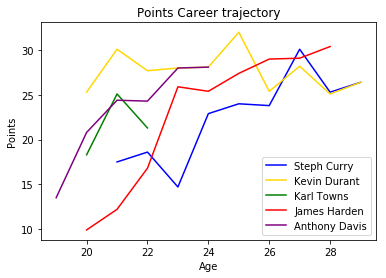

In [1268]:
plt.plot(df[df['player']=='Stephen Curry']['age'],df[df['player']=='Stephen Curry']['points'], color = 'blue',label = 'Steph Curry')
plt.plot(df[df['player']=='Kevin Durant']['age'],df[df['player']=='Kevin Durant']['points'], color = 'gold',label = 'Kevin Durant')
plt.plot(df[df['player']=='Karl-Anthony Towns']['age'],df[df['player']=='Karl-Anthony Towns']['points'], color = 'green',label = 'Karl Towns')
plt.plot(df[df['player']=='James Harden']['age'],df[df['player']=='James Harden']['points'], color = 'red',label = 'James Harden')
plt.plot(df[df['player']=='Anthony Davis']['age'],df[df['player']=='Anthony Davis']['points'], color = 'purple',label = 'Anthony Davis')

plt.title('Points Career trajectory')
plt.xlabel('Age')
plt.ylabel('Points')
plt.legend()

In [1277]:
df[(df['season']==2017) & (df['age']>30)]

,season,player,position,age,team,gamesPlayed,gamesStarted,minutes,points,rebounds,...,steals,blocks,turnovers,threes_made,FGM,FGA,FTM,FTA,starter,min_rank
4219,2017,LeBron James,PF,33.0,CLE,82,82,36.9,27.5,8.6,...,1.4,0.9,4.2,1.8,10.5,19.3,4.7,6.5,1,1
4232,2017,Taj Gibson,PF,32.0,MIN,82,82,33.2,12.2,7.1,...,0.8,0.7,1.1,0.1,5.2,9.0,1.7,2.3,1,14
4241,2017,Lou Williams,SG,31.0,LAC,79,19,32.8,22.6,2.5,...,1.1,0.2,3.0,2.4,7.4,16.9,5.5,6.2,0,23
4248,2017,LaMarcus Aldridge,C,32.0,SAS,75,75,33.5,23.1,8.5,...,0.6,1.2,1.5,0.4,9.2,18.0,4.5,5.3,1,30
4249,2017,Kyle Lowry,PG,31.0,TOR,78,78,32.2,16.2,5.6,...,1.1,0.2,2.3,3.1,5.2,12.1,2.9,3.3,1,31
4251,2017,Carmelo Anthony,PF,33.0,OKC,78,78,32.1,16.2,5.8,...,0.6,0.6,1.3,2.2,6.1,15.0,1.9,2.5,1,33
4254,2017,Dwight Howard,C,32.0,CHA,81,81,30.4,16.6,12.5,...,0.6,1.6,2.6,0.0,6.2,11.2,4.1,7.2,1,36
4261,2017,Marc Gasol,C,33.0,MEM,73,73,33.0,17.2,8.1,...,0.7,1.4,2.7,1.5,5.9,14.2,3.8,4.6,1,43
4263,2017,Goran Dragic,PG,31.0,MIA,75,75,31.7,17.3,4.1,...,0.8,0.2,2.2,1.5,6.5,14.3,2.9,3.6,1,45
4267,2017,Courtney Lee,SG,32.0,NYK,76,69,30.4,12.0,2.9,...,1.1,0.2,1.1,1.5,4.5,9.9,1.5,1.6,1,49


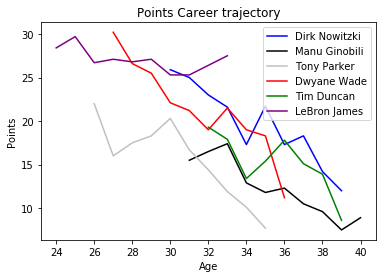

In [1295]:
players = ['Dirk Nowitzki','Manu Ginobili','Tony Parker','Dwyane Wade','Tim Duncan','LeBron James']
colors = ['blue','black','silver','red','green','purple']

for color,player in zip(colors,players):
    plt.plot(df[df['player']==player]['age'],df[df['player']==player]['points'], color = color,label = player)
    
plt.title('Points Career trajectory')
plt.xlabel('Age')
plt.ylabel('Points')
plt.legend()

In [1292]:
df[(df['season']==2012) &(df['team']=='MIA')][0:1]['player'].values

array(['LeBron James'], dtype=object)

In [191]:
plt.bar(df[df['player']=='Dirk Nowitzki']['points'],df[df['player']=='LeBron James']['points'])

NameError: name 'df' is not defined

TypeError: unsupported operand type(s) for -: 'list' and 'list'